In [213]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

def root_evaluator(G,Delta_t,Omega):
    ns_1=G*G
    root_insider=G**4 - (((4*kpa*kpa)/(Omega*Omega))) - 4*G*G*Delta_t/Omega 
    if(root_insider<0):
        ns_2=ns_1
        ns_3=ns_1
    else:
        ns_2=0.5*G*G - Delta_t/Omega + 0.5*np.real(np.sqrt(root_insider +0j))
        ns_3=0.5*G*G - Delta_t/Omega - 0.5*np.real(np.sqrt(root_insider +0j))
    return ns_1,ns_2,ns_3

def root_adjuster(roots,discriminant):
    if discriminant<0:
        for i in range(len(roots)):
            if(np.imag(roots[i])==0):
                real_soln=roots[i]*np.ones(len(roots))
    else:
        real_soln=roots
    return real_soln

def phase_gap_evaluator(roots,discriminant,A):
    sign=0  #taking 0 stable roots initially (signifying instability region)
    gap=np.zeros(3)
    root_stability_values=np.zeros(3)
    phaser_val=0
    if discriminant>0:
        for i in range(3):
            root_stability_values[i]=(-(np.sign(np.max(np.real(np.linalg.eigvals(A[i,:,:]))))-1)/2)
            sign=sign + (-(np.sign(np.max(np.real(np.linalg.eigvals(A[i,:,:]))))-1)/2)
            gap[i]=np.min(np.abs(np.real(np.linalg.eigvals(A[i,:,:]))))
            phaser_val+=(2**i)*root_stability_values[i]
    else:
        for i in range(3):
            root_stability_values[i]=(-(np.sign(np.max(np.real(np.linalg.eigvals(A[i,:,:]))))-1)/2)
            phaser_val+=(2**i)*root_stability_values[i]
        sign=sign + (-(np.sign(np.max(np.real(np.linalg.eigvals(A[0,:,:]))))-1)/2)
        gap=np.min(np.abs(np.real(np.linalg.eigvals(A[0,:,:]))))*np.ones(3)
    return sign,gap,root_stability_values,phaser_val

def entanglement_finder(A,D):
    LN0=np.zeros(3)
    squeezing0=np.zeros(3)
    LN=np.zeros(3)
    squeezing=np.zeros(3)
    for i in range(3):
        V=linalg.solve_continuous_lyapunov(A[i,:,:],-D)
        LN[i]=np.abs(logarithmic_negativity(V[2:6,2:6]))#DW-DW
        squeezing[i]=np.abs(np.min(np.linalg.eigvals(V[2:6,2:6])))#DW-DW
        LN0[i]=np.abs(logarithmic_negativity(V[0:4,0:4]))#photon-DW
        squeezing0[i]=np.abs(np.min(np.linalg.eigvals(V[0:4,0:4])))#photon-DW
    return LN0,squeezing0,LN,squeezing

def logarithmic_negativity(V):
    """
    Calculates the logarithmic negativity given a symmetrized covariance
    matrix, see :func:`qutip.continous_variables.covariance_matrix`. Note that
    the two-mode field state that is described by `V` must be Gaussian for this
    function to applicable.

    Parameters
    ----------

    V : *2d array*
        The covariance matrix.

    Returns
    -------

    N : float 
        The logarithmic negativity for the two-mode Gaussian state
        that is described by the the Wigner covariance matrix V.

    """

    A = V[0:2, 0:2]
    B = V[2:4, 2:4]
    C = V[0:2, 2:4]

    sigma = np.linalg.det(A) + np.linalg.det(B) - 2 * np.linalg.det(C)
    nu_ = sigma / 2 - np.sqrt(sigma ** 2 - 4 * np.linalg.det(V)) / 2
    if nu_ < 0.0:
        return 0.0
    nu = np.sqrt(nu_)
    lognu = -np.log(2 * nu)
    # print(nu)
    logneg = max(0, lognu)

    return logneg

hbar=1.0545718*1e-34
kb=1.38064852*1e-23
N=1 #number of pinned DW/CSL modes
Nbins=201#number of bins for parameter variation
o1=2*np.pi*1e9;o2=2*np.pi*1e9;oa=2*np.pi*1e12
kp1=0.001*o1;kp2=0.001*o1;kpa=0.002*o1
# kp1=0.0001*o1;kp2=0.0001*o1;kpa=0.1*o1
g1=-0.001*o1;g2=-0.001*o1
T=2e-3
n_1th=1/np.expm1(hbar*o1/(kb*T))
n_2th=1/np.expm1(hbar*o2/(kb*T))
N0=1/np.expm1(hbar*oa/(kb*T))
r=0.0;theta=np.pi;phi=np.pi/2

D0=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) + 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
D1=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) - 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
D=np.zeros(6);D[0]=D0;D[1]=D1;D[2]=kp1*(2.0*n_1th+1.0);D[3]=kp1*(2.0*n_1th+1.0);D[4]=kp2*(2.0*n_2th+1.0);D[5]=kp2*(2.0*n_2th+1.0);D=np.diag(D)
# D=np.diag(np.array([kpa,kpa,gamma,gamma]))

# G_vec=np.linspace(0.001,0.6,Nbins)*o1
# Delta_t_vec=np.linspace(-500,150,Nbins)*o1
G_vec=np.linspace(0.001,5,Nbins)*o1
Delta_t_vec=np.linspace(-20,20,Nbins)*o1
A=np.zeros((3,6,6),dtype=np.complex128)
alpha_mat=np.zeros((3,len(Delta_t_vec),len(G_vec)),dtype=np.complex128)
nas_mat=np.zeros((3,len(Delta_t_vec),len(G_vec)),dtype=np.complex128)
beta1_mat=np.zeros((3,len(Delta_t_vec),len(G_vec)),dtype=np.complex128)
beta2_mat=np.zeros((3,len(Delta_t_vec),len(G_vec)),dtype=np.complex128)

# ns_mat=np.zeros((3,len(G_vec),len(Delta_t_vec)))
Delta_d=np.zeros((3,len(G_vec),len(Delta_t_vec)))
phaser=np.zeros((len(G_vec),len(Delta_t_vec)));phaser1=np.zeros((len(G_vec),len(Delta_t_vec)));root_stability=np.zeros((3,len(G_vec),len(Delta_t_vec)))
discriminant=np.zeros((len(G_vec),len(Delta_t_vec)))
Eab=np.zeros((3,len(G_vec),len(Delta_t_vec)));Eab_max=np.zeros((len(G_vec),len(Delta_t_vec)))
E12=np.zeros((3,len(G_vec),len(Delta_t_vec)));E12_max=np.zeros((len(G_vec),len(Delta_t_vec)))
squeezing=np.zeros((3,len(G_vec),len(Delta_t_vec)));squeezing_min=np.zeros((len(G_vec),len(Delta_t_vec)))
squeezing12=np.zeros((3,len(G_vec),len(Delta_t_vec)));squeezing12_min=np.zeros((len(G_vec),len(Delta_t_vec)))

for iy,G in enumerate(G_vec):
    for ix,Delta_t in enumerate(Delta_t_vec):
        Omega=2*o1*g1*g1/(g1*g1*(o1**2 + kp1**2)) + 2*o2*g2*g2/(g1*g1*(o2**2 + kp2**2));xi=np.sqrt((Delta_t**2 + kpa**2)*G*G)
        nas_mat[:,ix,iy]=root_evaluator(G,Delta_t,Omega);ns_1,ns_2,ns_3=nas_mat[:,ix,iy]
        alpha_mat[:,ix,iy]=1j*xi/(Delta_t + Omega*(nas_mat[:,ix,iy]-ns_1) + 1j*kpa)
        beta1_mat[:,ix,iy]=-(g1*np.abs(alpha_mat[:,ix,iy])**2)/(g1*(o1-1j*kp1));beta2_mat[:,ix,iy]=-(g2*np.abs(alpha_mat[:,ix,iy])**2)/(g1*(o2-1j*kp2))
        Delta=Delta_t - Omega*G*G
        a=1;b=2*Delta/Omega;c=(Delta**2 + kpa**2)/(Omega**2);d=-(xi/Omega)**2
        p=[a,b,c,d];discriminant[iy,ix]=np.sign(( 4*(b**2 - 3*a*c)**3 - (2*b**3 - 9*a*b*c + 27*a*a*d)**2 )/(27*a*a))
        A[:,0,0]=-kpa*np.ones(3);A[:,0,1]=Delta+Omega*nas_mat[:,ix,iy];A[:,0,2]=2*g1*np.imag(alpha_mat[:,ix,iy])/g1;A[:,0,3]=np.zeros(3);A[:,0,4]=2*g2*np.imag(alpha_mat[:,ix,iy])/g1;A[:,0,5]=np.zeros(3)
        A[:,1,0]=-A[:,0,1];A[:,1,1]=-kpa*np.ones(3);A[:,1,2]=2*g1*np.real(alpha_mat[:,ix,iy])/g1;A[:,1,3]=np.zeros(3);A[:,1,4]=2*g2*np.real(alpha_mat[:,ix,iy])/g1;A[:,1,5]=np.zeros(3)
        A[:,2,0]=np.zeros(3);A[:,2,1]=np.zeros(3);A[:,2,2]=-kp1*np.ones(3);A[:,2,3]=-o1*np.ones(3);A[:,2,4]=np.zeros(3);A[:,2,5]=np.zeros(3)
        A[:,3,0]=2*g1*np.real(alpha_mat[:,ix,iy])/g1;A[:,3,1]=-2*g1*np.imag(alpha_mat[:,ix,iy])/g1;A[:,3,2]=o1*np.ones(3);A[:,3,3]=-kp1*np.ones(3);A[:,3,4]=np.zeros(3);A[:,3,5]=np.zeros(3)
        A[:,4,0]=np.zeros(3);A[:,4,1]=np.zeros(3);A[:,4,2]=np.zeros(3);A[:,4,3]=np.zeros(3);A[:,4,4]=-kp2*np.ones(3);A[:,4,5]=-o2*np.ones(3)
        A[:,5,0]=2*g2*np.real(alpha_mat[:,ix,iy])/g1;A[:,5,1]=-2*g2*np.imag(alpha_mat[:,ix,iy])/g1;A[:,5,2]=np.zeros(3);A[:,5,3]=np.zeros(3);A[:,5,4]=o2*np.ones(3);A[:,5,5]=-kp2*np.ones(3)
        phaser[iy,ix],Delta_d[:,iy,ix],root_stability[:,iy,ix],phaser1[iy,ix]=phase_gap_evaluator(nas_mat[:,ix,iy],discriminant[iy,ix],A)
        Eab[:,iy,ix],squeezing[:,iy,ix],E12[:,iy,ix],squeezing12[:,iy,ix]=entanglement_finder(A,D)
        Eab_max[iy,ix]=np.max(Eab[:,iy,ix]*root_stability[:,iy,ix])
        squeezing_min[iy,ix]=np.min(squeezing[:,iy,ix]*root_stability[:,iy,ix] + 10*(1-root_stability[:,iy,ix]))
        E12_max[iy,ix]=np.max(E12[:,iy,ix]*root_stability[:,iy,ix])
        squeezing12_min[iy,ix]=np.min(np.min(squeezing12[:,iy,ix]*root_stability[:,iy,ix] + 10*(1-root_stability[:,iy,ix])))

print("Calculations Completed!")

/tmp/ipykernel_81113/148124540.py:107: RuntimeWarning: overflow encountered in expm1
  N0=1/np.expm1(hbar*oa/(kb*T))


Calculations Completed!


/tmp/ipykernel_81113/3048496197.py:4: RuntimeWarning: divide by zero encountered in divide
  G12_vec=np.sqrt( -(kpa**2 + Delta_t_vec**2)/(2*Omega*Delta_t_vec))
/tmp/ipykernel_81113/3048496197.py:4: RuntimeWarning: invalid value encountered in sqrt
  G12_vec=np.sqrt( -(kpa**2 + Delta_t_vec**2)/(2*Omega*Delta_t_vec))
luatex: /opt/intel/oneapi/intelpython/python3.12/lib/libcurl.so.4: no version information available (required by /usr/bin/../lib/../lib/libmiktex-packagemanager.so.11)


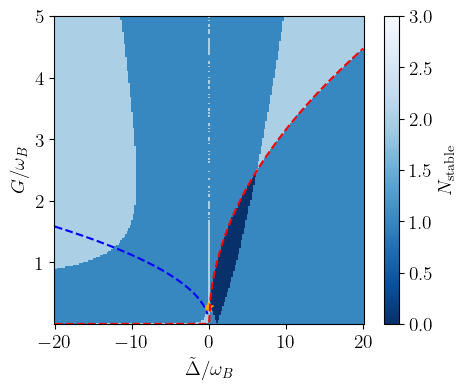

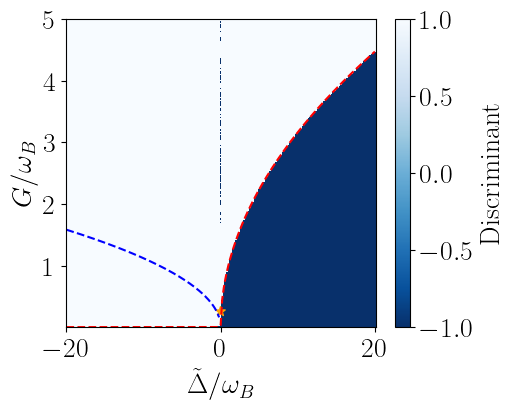

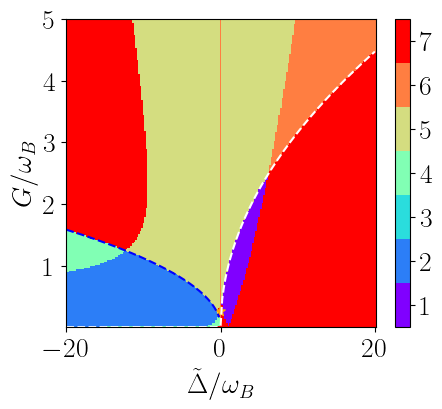

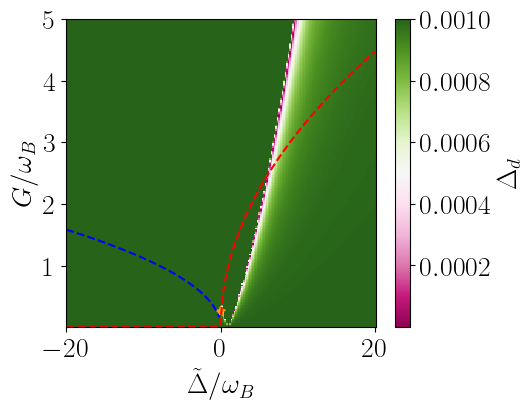

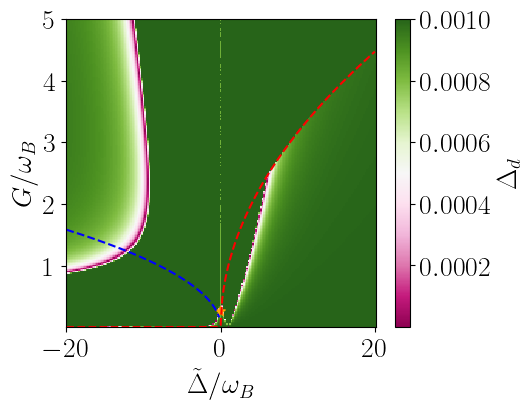

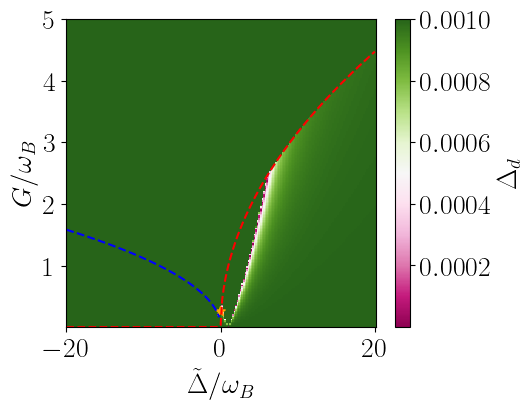

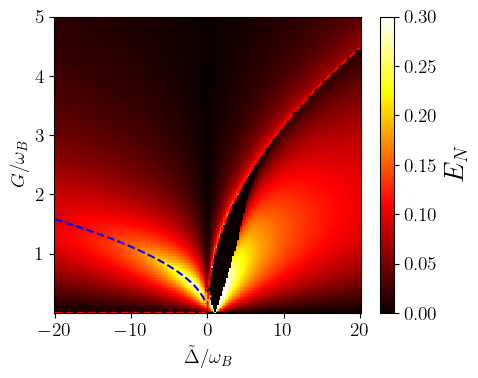

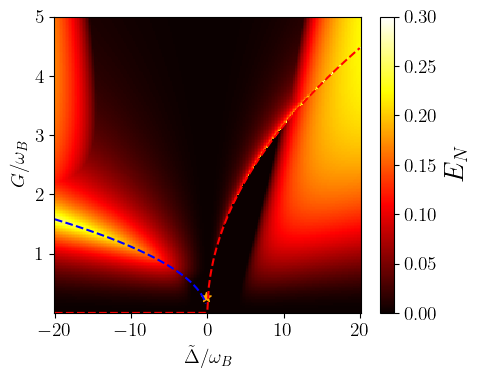

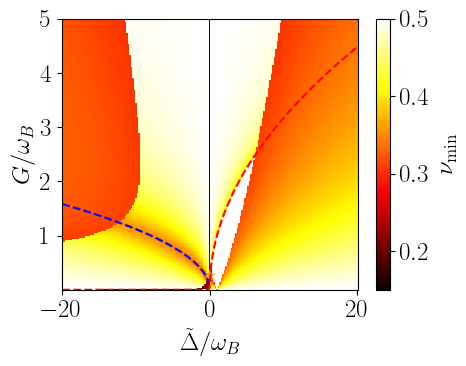

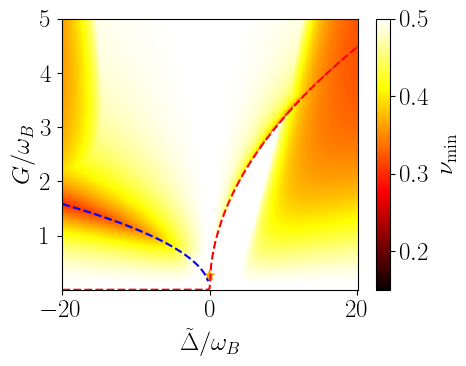

In [2]:
#critical point
Delta_c=-1/(4*np.sqrt(3));G_c=np.sqrt(1/(4*np.sqrt(3)))/np.sqrt(2)
G23_vec=np.sqrt( 2*(Delta_t_vec + np.sqrt(Delta_t_vec**2 + kpa**2))/Omega )
G12_vec=np.sqrt( -(kpa**2 + Delta_t_vec**2)/(2*Omega*Delta_t_vec))

# Y=parameter_vec0/o1
Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=phaser;Z1=discriminant

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='Blues_r', shading='nearest',vmin=0,vmax=3)#,norm=colors.LogNorm()#Blues_r
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$N_{\rm stable}$')
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
#plt.xticks(np.arange(0, 1, step=0.2))
# plt.yscale('log')
# axes.plot(parameter_vec1/o1,hbar*oa*(y_vec1**2)/kpa,'--',color='red')
# axes.plot(parameter_vec1/o1,hbar*oa*(y_vec2**2)/kpa,'--',color='brown')
# axes.plot(parameter_vec1/o1,y_vec1/o1,'--',color='red')
# axes.plot(parameter_vec1/o1,y_vec2/o1,'--',color='brown')
# axes.scatter(np.sqrt(3)*kpa/o1,(np.sqrt((8*kpa**3)/(3*np.sqrt(3)*Omega))**2)*hbar*oa/kpa,marker='*',color='orange',s=50)#,label='Critical Point')
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)#,label='Critical Point')
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.legend(frameon=False, fontsize=12, labelcolor='white')
# plt.ylim(parameter_vec0[0]/o1,parameter_vec0[-1]/o1)
# plt.ylim((parameter_vec0[0]**2)*hbar*oa/kpa,(parameter_vec0[-1]**2)*hbar*oa/kpa)
# plt.tight_layout()
# plt.savefig("Phases_old.png", dpi=400)
plt.show()

np.savetxt("stability_o2_by_o1=%.1f.txt" %(o2/o1), Z)

Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=discriminant

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':20})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='Blues_r', shading='nearest')#,norm=colors.LogNorm()#Blues_r
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'Discriminant', fontsize=20)
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
#plt.xticks(np.arange(0, 1, step=0.2))
# plt.yscale('log')
plt.show()

Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=phaser1

cmap = plt.colormaps['rainbow']
colorx = cmap(np.linspace(0, 1, 7))
discrete_cmap = colors.ListedColormap(colorx)
plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':20})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap=discrete_cmap, shading='nearest')#,norm=colors.LogNorm()#Blues_r
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
cbar=plt.colorbar(im, ax=axes, ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])#.set_label(r'Phases', fontsize=20)
cbar.ax.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8'])
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='white')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
#plt.xticks(np.arange(0, 1, step=0.2))
# plt.yscale('log')
plt.show()
np.savetxt("All_phases_o2_by_o1_Z=%.1f.txt" %(o2/o1), Z)
np.savetxt("All_phases_o2_by_o1_line=%.1f.txt" %(o2/o1), np.c_[Delta_t_vec/o1,G12_vec/o1,G23_vec/o1])


Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=Delta_d[0,:,:]/o1

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':20})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='PiYG', shading='nearest')
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$\Delta_d$', fontsize=20)
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
#plt.xticks(np.arange(0, 1, step=0.2))
# plt.yscale('log')
plt.show()

Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=Delta_d[1,:,:]/o1

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':20})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='PiYG', shading='nearest')
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$\Delta_d$', fontsize=20)
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
#plt.xticks(np.arange(0, 1, step=0.2))
# plt.yscale('log')
plt.show()

Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=Delta_d[2,:,:]/o1

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':20})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='PiYG', shading='nearest')
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$\Delta_d$', fontsize=20)
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
#plt.xticks(np.arange(0, 1, step=0.2))
# plt.yscale('log')
plt.show()

Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=Eab_max#*root_stability[2,:,:]

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='hot', shading='nearest',vmin=0,vmax=0.3)#,vmin=0,vmax=1/3)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$E_N$', fontsize=20)
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

np.savetxt("Entab_max_o2_by_o1=%.1f.txt" %(o2/o1), Z)

Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=E12_max#*root_stability[2,:,:]

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='hot', shading='nearest',vmin=0,vmax=0.3)#,vmin=0,vmax=1/3)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$E_N$', fontsize=20)
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

np.savetxt("Ent12_max_o2_by_o1=%.1f.txt" %(o2/o1), Z)

Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=squeezing_min#*root_stability[2,:,:]

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':18})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='hot', shading='nearest',vmin=0.15,vmax=0.5)#,vmin=0.2,vmax=0.5)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=18)
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

np.savetxt("Squeeab_min_o2_by_o1=%.1f.txt" %(o2/o1), Z)

Y=G_vec/o1#G vector
X=Delta_t_vec/o1#delta vector
Z=squeezing12_min#*root_stability[2,:,:]

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':18})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='hot', shading='nearest',vmin=0.15,vmax=0.5)#,vmin=0.2,vmax=0.5)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=18)
axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_xlabel(r'$\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'$G/ \omega_B$')
axes.set_facecolor("black")
plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

np.savetxt("Squee12_min_o2_by_o1=%.1f.txt" %(o2/o1), Z)

In [12]:
np.min(squeezing_min)

0.1670350034578394

[]

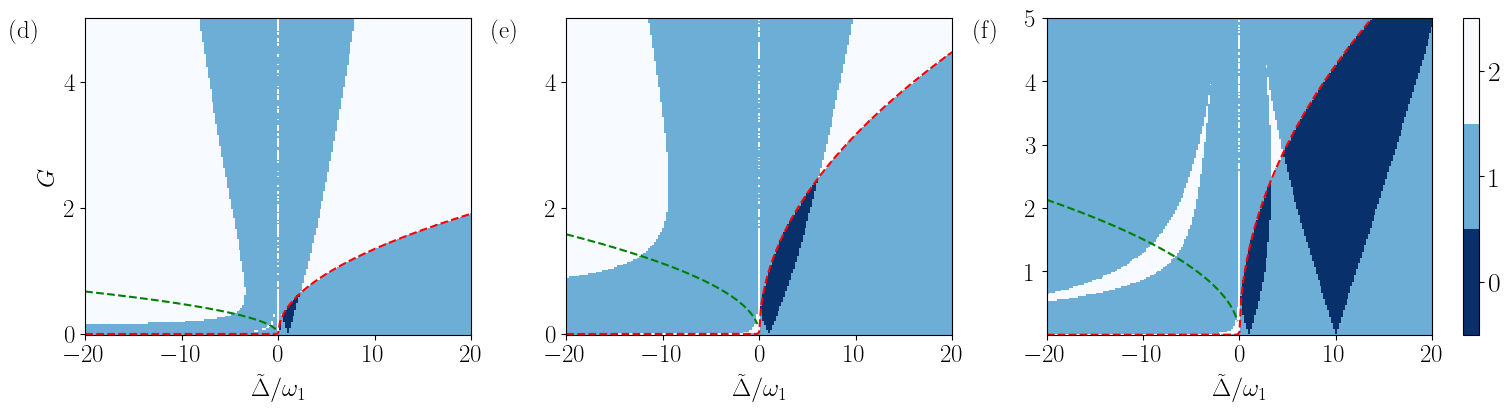

In [13]:
cmap = plt.colormaps['rainbow']
colorx = cmap(np.linspace(0, 1, 7))
discrete_cmap = colors.ListedColormap(colorx)

Zp1=np.loadtxt("All_phases_o2_by_o1_Z=1.0.txt")
Zp10=np.loadtxt("All_phases_o2_by_o1_Z=10.0.txt")
Zp0p1=np.loadtxt("All_phases_o2_by_o1_Z=0.1.txt")

Zsp1=np.loadtxt("stability_o2_by_o1=1.0.txt")
Zsp10=np.loadtxt("stability_o2_by_o1=10.0.txt")
Zsp0p1=np.loadtxt("stability_o2_by_o1=0.1.txt")

Xp=np.loadtxt("All_phases_o2_by_o1_line=1.0.txt")[:,0]
Gp1=np.loadtxt("All_phases_o2_by_o1_line=1.0.txt")[:,1]
Gp10=np.loadtxt("All_phases_o2_by_o1_line=10.0.txt")[:,1]
Gp0p1=np.loadtxt("All_phases_o2_by_o1_line=0.1.txt")[:,1]
G23p1=np.loadtxt("All_phases_o2_by_o1_line=1.0.txt")[:,2]
G23p10=np.loadtxt("All_phases_o2_by_o1_line=10.0.txt")[:,2]
G23p0p1=np.loadtxt("All_phases_o2_by_o1_line=0.1.txt")[:,2]

cmap1 = plt.colormaps['Blues_r']
# cmap = plt.colormaps['rainbow']
colorx1 = cmap1(np.linspace(0, 1, 3))
discrete_cmap1 = colors.ListedColormap(colorx1)

Y=G_vec/o1
X=Delta_t_vec/o1
X,Y = np.meshgrid(X,Y)
# Subplots environment for clubbing and labelling multiple figures
import matplotlib.transforms as mtransforms
ncols=3;nrows=1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4),layout="constrained", sharex=True)#, sharey=True);,layout="constrained"
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':20})
plt.rc('text', usetex=True)
# add an artist, in this case a nice label in the middle...
label_list=['(d)','(e)','(f)','(g)']
# axs[1].set_ylim(1e-38,1e-29)
for row in range(nrows):
    for col in range(ncols):
        trans = mtransforms.ScaledTranslation(-0.6, 0, fig.dpi_scale_trans)
        # axs[row].annotate(label_list[row], (0.5, 0.5),transform=axs[row].transAxes+trans,ha='center', va='center', fontsize=14,color='black')
        axs[col].text(0.0, 1.0, label_list[col], transform=axs[col].transAxes + trans,
            fontsize='18', ha='center', va='top', fontfamily='serif',
            bbox=dict(facecolor='1', edgecolor='none', pad=0.3))
# Adjust the padding between subplots
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.12, top=0.9, wspace=0.1, hspace=0.1)
# o2=0.1*o1
# Omega=2*( o1*G1*G1/(o1**2 + kp1**2) + o2*G2*G2/(o2**2 + kp2**2))
axs[0].pcolormesh(X,Y,Zsp0p1, cmap=discrete_cmap1, shading='nearest')#,norm=colors.LogNorm()
# axs[0].pcolormesh(X,Y,Zsp0p1, cmap=discrete_cmap, shading='nearest')
# plt.colorbar(im, ax=axs[0]).set_label(r'$N_{\rm stable}$')
axs[0].plot(Xp,Gp0p1,'--',color='green')
axs[0].plot(Xp,G23p0p1,'--',color='red')

axs[1].pcolormesh(X,Y,Zsp1, cmap=discrete_cmap1, shading='nearest')#,norm=colors.LogNorm()
# plt.colorbar(im, ax=axs[1]).set_label(r'$N_{\rm stable}$')
axs[1].plot(Xp,Gp1,'--',color='green')
axs[1].plot(Xp,G23p1,'--',color='red')

# im = axs[2].pcolormesh(X,Y,Zp10, cmap='Blues_r', shading='nearest')
im = axs[2].pcolormesh(X,Y,Zsp10, cmap=discrete_cmap1, shading='nearest')#,vmin=0,vmax=3)#,norm=colors.LogNorm()
# plt.colorbar(im, ax=axs[2]).set_label(r'$N_{\rm stable}$')
# cbar=plt.colorbar(im, ax=axs[2], ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])#.set_label(r'Phases', fontsize=20)
# cbar.ax.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8'])
cbar=plt.colorbar(im, ax=axs[2], ticks=[2/3 - 1/3,4/3 - 1/3,2 - 1/3])#.set_label(r'Phases', fontsize=20)
cbar.ax.set_yticklabels(['0', '1', '2'])
axs[2].plot(Xp,Gp10,'--',color='green')
axs[2].plot(Xp,G23p10,'--',color='red')

axs[0].set_xlim(Delta_t_vec[0]/o1,Delta_t_vec[-1]/o1)
axs[2].set_ylim(G_vec[0]/o1,G_vec[-1]/o1)
axs[0].set_xlabel(r'$\tilde{\Delta}/\omega_1$')
axs[1].set_xlabel(r'$\tilde{\Delta}/\omega_1$')
axs[2].set_xlabel(r'$\tilde{\Delta}/\omega_1$')
axs[0].set_ylabel(r'$G$')
axs[1].set_facecolor("black")

# axs[2].set_yscale("log")
# axs[1].set_yscale("log")
# axs[0].set_yscale("log")
# axs[0].legend(prop={'weight': 'normal', "size": 14, 'stretch': 'normal'},frameon=False, labelcolor='white')
# axs[1].legend(prop={'weight': 'normal', "size": 14, 'stretch': 'normal'},frameon=False, labelcolor='white')
# axs[2].legend(prop={'weight': 'normal', "size": 14, 'stretch': 'normal'},frameon=False, labelcolor='white')
# plt.tight_layout()
# plt.savefig("phases1.png",dpi=400)
plt.plot()

### Cutting across the maxima of entanglement:

/tmp/ipykernel_1710286/1077161894.py:12: RuntimeWarning: overflow encountered in expm1
  N0=1/np.expm1(hbar*oa/(kb*T))
/tmp/ipykernel_1710286/2054553273.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  squeezing[i]=np.min(np.linalg.eigvals(V[2:6,2:6]))#DW-DW
/tmp/ipykernel_1710286/2054553273.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  squeezing0[i]=np.min(np.linalg.eigvals(V[0:4,0:4]))#photon-DW
/tmp/ipykernel_1710286/2054553273.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  LN[i]=logarithmic_negativity(V[2:6,2:6])#DW-DW
/tmp/ipykernel_1710286/2054553273.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  LN0[i]=logarithmic_negativity(V[0:4,0:4])#photon-DW


[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0.  1.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -0.  1.]
[-0. -

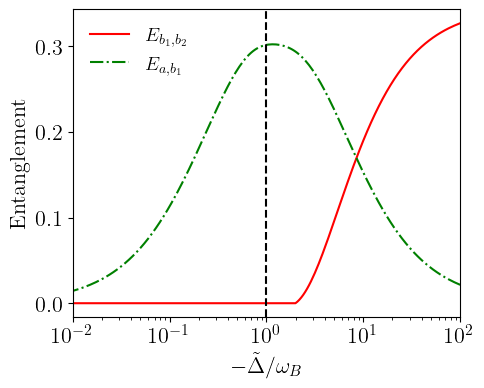

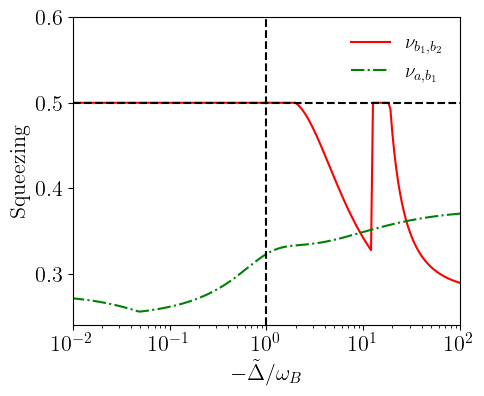

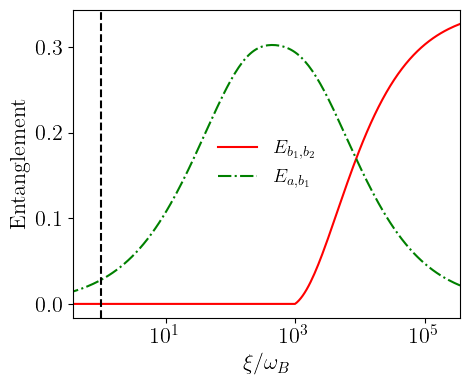

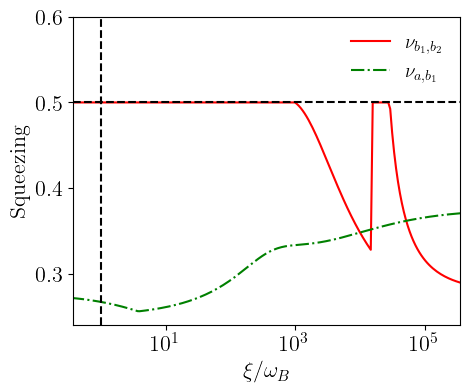

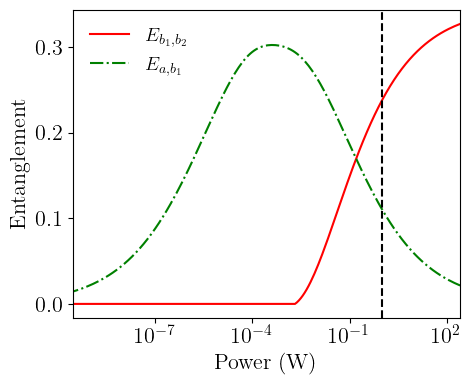

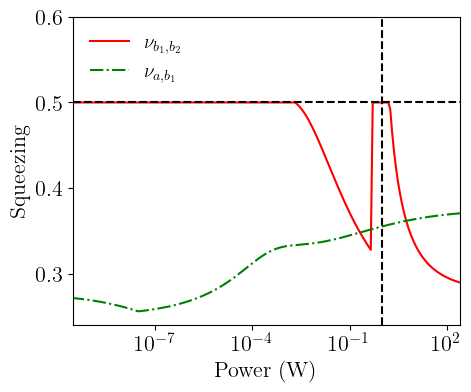

In [50]:
hbar=1.0545718*1e-34
kb=1.38064852*1e-23
N=1 #number of pinned DW/CSL modes
Nbins=201#number of bins for parameter variation
o1=2*np.pi*1e9;o2=2*np.pi*1e9;oa=2*np.pi*1e12
kp1=0.001*o1;kp2=0.001*o1;kpa=0.002*o1
# kp1=0.0001*o1;kp2=0.0001*o1;kpa=0.1*o1
g1=-0.001*o1;g2=-0.001*o1
T=2e-3
n_1th=1/np.expm1(hbar*o1/(kb*T))
n_2th=1/np.expm1(hbar*o2/(kb*T))
N0=1/np.expm1(hbar*oa/(kb*T))
r=0.0;theta=np.pi;phi=np.pi/2

D0=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) + 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
D1=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) - 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
D=np.zeros(6);D[0]=D0;D[1]=D1;D[2]=kp1*(2.0*n_1th+1.0);D[3]=kp1*(2.0*n_1th+1.0);D[4]=kp2*(2.0*n_2th+1.0);D[5]=kp2*(2.0*n_2th+1.0);D=np.diag(D)

Delta_t_vec=-np.logspace(2,-2,Nbins)*o1
G12_vec=np.sqrt( -(kpa**2 + Delta_t_vec**2)/(2*Omega*Delta_t_vec))
xi_vec=np.sqrt((Delta_t_vec**2 + kpa**2)*G12_vec*G12_vec)/(-g1)
Pin_vec=(hbar*oa*(xi_vec)**2)/kpa

E12_cut=np.zeros((3,len(Delta_t_vec)));E12_cut_max=np.zeros(len(Delta_t_vec))
Eab_cut=np.zeros((3,len(Delta_t_vec)));Eab_cut_max=np.zeros(len(Delta_t_vec))
squeezing12_cut=np.zeros((3,len(Delta_t_vec)));squeezing12_cut_min=np.zeros(len(Delta_t_vec))
squeezingab_cut=np.zeros((3,len(Delta_t_vec)));squeezingab_cut_min=np.zeros(len(Delta_t_vec))
eps=o1*1e-6
scale=1
for ix,Delta_t in enumerate(Delta_t_vec):
    G=G12_vec[ix]+eps
    Omega=2*o1*g1*g1/(g1*g1*(o1**2 + kp1**2)) + 2*o2*g2*g2/(g1*g1*(o2**2 + kp2**2));xi=np.sqrt((Delta_t**2 + kpa**2)*G*G)
    nas=np.array(root_evaluator(G,Delta_t,Omega));ns_1,ns_2,ns_3=nas
    alpha=1j*xi/(Delta_t + Omega*(nas-ns_1) + 1j*kpa)
    Delta=Delta_t - Omega*G*G
    a=1;b=2*Delta/(Omega);c=(Delta**2 + kpa**2)/(Omega**2);d=(-(xi/Omega)**2)
    p=[a,b,c,d];discriminant_temp=np.sign(( 4*(b**2 - 3*a*c)**3 - (2*b**3 - 9*a*b*c + 27*a*a*d)**2 )/(27*a*a))
    A[:,0,0]=-kpa*np.ones(3);A[:,0,1]=Delta+Omega*nas;A[:,0,2]=2*g1*np.imag(alpha)/g1;A[:,0,3]=np.zeros(3);A[:,0,4]=2*g2*np.imag(alpha)/g1;A[:,0,5]=np.zeros(3)
    A[:,1,0]=-A[:,0,1];A[:,1,1]=-kpa*np.ones(3);A[:,1,2]=2*g1*np.real(alpha)/g1;A[:,1,3]=np.zeros(3);A[:,1,4]=2*g2*np.real(alpha)/g1;A[:,1,5]=np.zeros(3)
    A[:,2,0]=np.zeros(3);A[:,2,1]=np.zeros(3);A[:,2,2]=-kp1*np.ones(3);A[:,2,3]=-o1*np.ones(3);A[:,2,4]=np.zeros(3);A[:,2,5]=np.zeros(3)
    A[:,3,0]=2*g1*np.real(alpha)/g1;A[:,3,1]=-2*g1*np.imag(alpha)/g1;A[:,3,2]=o1*np.ones(3);A[:,3,3]=-kp1*np.ones(3);A[:,3,4]=np.zeros(3);A[:,3,5]=np.zeros(3)
    A[:,4,0]=np.zeros(3);A[:,4,1]=np.zeros(3);A[:,4,2]=np.zeros(3);A[:,4,3]=np.zeros(3);A[:,4,4]=-kp2*np.ones(3);A[:,4,5]=-o2*np.ones(3)
    A[:,5,0]=2*g2*np.real(alpha)/g1;A[:,5,1]=-2*g2*np.imag(alpha)/g1;A[:,5,2]=np.zeros(3);A[:,5,3]=np.zeros(3);A[:,5,4]=o2*np.ones(3);A[:,5,5]=-kp2*np.ones(3)
    phaser_temp,Delta_d_temp,root_stability_temp,phaser1_temp=phase_gap_evaluator(nas,discriminant_temp,A)
    print(root_stability_temp)
    Eab_cut[:,ix],squeezingab_cut[:,ix],E12_cut[:,ix],squeezing12_cut[:,ix]=entanglement_finder(A,D)
    Eab_cut_max[ix]=np.max(np.real(Eab_cut[:,ix])*root_stability_temp);squeezingab_cut_min[ix]=np.max(np.real(squeezingab_cut[:,ix])*root_stability_temp)
    E12_cut_max[ix]=np.max(np.real(E12_cut[:,ix])*root_stability_temp);squeezing12_cut_min[ix]=np.max(np.real(squeezing12_cut[:,ix])*root_stability_temp)

X=-Delta_t_vec/o1
Y=Eab_cut_max;Y1=E12_cut_max
Ys=squeezingab_cut_min;Ys1=squeezing12_cut_min

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rc('text', usetex=True)
axes = plt.axes()
# plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
axes.plot(X,Y1,color='red',label=r'$E_{b_1,b_2}$')
axes.plot(X,Y,'-.',color='green',label=r'$E_{a,b_1}$')
plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=0.3,linestyle='dashed',color='black')
axes.set_xlabel(r'$-\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'Entanglement')
plt.xlim(X[-1],X[0])
# plt.ylim(0,0.3)
plt.xscale('log')
# plt.yscale('log')
# axes.set_facecolor("black")
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.legend(frameon=False,fontsize=14)
# plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rc('text', usetex=True)
axes = plt.axes()
# plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
axes.plot(X,Ys1,color='red',label=r'$\nu_{b_1,b_2}$')
axes.plot(X,Ys,'-.',color='green',label=r'$\nu_{a,b_1}$')
plt.axvline(x=1,linestyle='dashed',color='black')
plt.axhline(y=1/2,linestyle='dashed',color='black')
axes.set_xlabel(r'$-\tilde{\Delta}/\omega_B$')
axes.set_ylabel(r'Squeezing')
plt.xlim(X[-1],X[0])
plt.ylim(0.24,0.6)
plt.xscale('log')
plt.legend(frameon=False,fontsize=14)
# plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# plt.yscale('log')
# axes.set_facecolor("black")
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

X=xi_vec/(o1)
Y=Eab_cut_max;Y1=E12_cut_max
Ys=squeezingab_cut_min;Ys1=squeezing12_cut_min

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rc('text', usetex=True)
axes = plt.axes()
# plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
axes.plot(X,Y1,color='red',label=r'$E_{b_1,b_2}$')
axes.plot(X,Y,'-.',color='green',label=r'$E_{a,b_1}$')
plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=0.3,linestyle='dashed',color='black')
axes.set_xlabel(r'$\xi/\omega_B$')
axes.set_ylabel(r'Entanglement')
plt.xlim(X[-1],X[0])
# plt.ylim(0,0.3)
plt.xscale('log')
# plt.yscale('log')
# axes.set_facecolor("black")
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.legend(frameon=False,fontsize=14)
# plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rc('text', usetex=True)
axes = plt.axes()
# plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
axes.plot(X,Ys1,color='red',label=r'$\nu_{b_1,b_2}$')
axes.plot(X,Ys,'-.',color='green',label=r'$\nu_{a,b_1}$')
plt.axvline(x=1,linestyle='dashed',color='black')
plt.axhline(y=1/2,linestyle='dashed',color='black')
axes.set_xlabel(r'$\xi/\omega_B$')
axes.set_ylabel(r'Squeezing')
plt.xlim(X[-1],X[0])
plt.ylim(0.24,0.6)
plt.xscale('log')
plt.legend(frameon=False,fontsize=14)
# plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# plt.yscale('log')
# axes.set_facecolor("black")
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

X=Pin_vec
Y=Eab_cut_max;Y1=E12_cut_max
Ys=squeezingab_cut_min;Ys1=squeezing12_cut_min

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rc('text', usetex=True)
axes = plt.axes()
# plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
axes.plot(X,Y1,color='red',label=r'$E_{b_1,b_2}$')
axes.plot(X,Y,'-.',color='green',label=r'$E_{a,b_1}$')
plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=0.3,linestyle='dashed',color='black')
axes.set_xlabel(r'Power (W)')
axes.set_ylabel(r'Entanglement')
plt.xlim(X[-1],X[0])
# plt.ylim(0,0.3)
plt.xscale('log')
# plt.yscale('log')
# axes.set_facecolor("black")
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.legend(frameon=False,fontsize=14)
# plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rc('text', usetex=True)
axes = plt.axes()
# plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
axes.plot(X,Ys1,color='red',label=r'$\nu_{b_1,b_2}$')
axes.plot(X,Ys,'-.',color='green',label=r'$\nu_{a,b_1}$')
plt.axvline(x=1,linestyle='dashed',color='black')
plt.axhline(y=1/2,linestyle='dashed',color='black')
axes.set_xlabel(r'Power (W)')
axes.set_ylabel(r'Squeezing')
plt.xlim(X[-1],X[0])
plt.ylim(0.24,0.6)
plt.xscale('log')
plt.legend(frameon=False,fontsize=14)
# plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# plt.yscale('log')
# axes.set_facecolor("black")
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

In [52]:
(G12_vec/(-g1))[-1]

36.055530782391756

### Temperature Dependence:

/tmp/ipykernel_81113/52975907.py:13: RuntimeWarning: overflow encountered in expm1
  N0=1/np.expm1(hbar*oa/(kb*T))
/tmp/ipykernel_81113/52975907.py:33: RuntimeWarning: overflow encountered in expm1
  n_1th=1/np.expm1(hbar*o1/(kb*T))
/tmp/ipykernel_81113/52975907.py:34: RuntimeWarning: overflow encountered in expm1
  n_2th=1/np.expm1(hbar*o2/(kb*T))


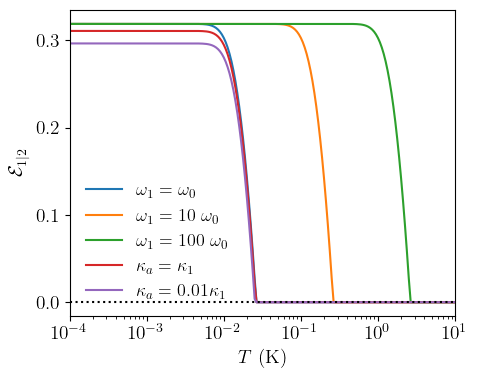

In [237]:
hbar=1.0545718*1e-34
kb=1.38064852*1e-23
N=1 #number of pinned DW/CSL modes
Nbins=201#number of bins for parameter variation
o10=2*np.pi*1e9#;o2=2*np.pi*1e9
o1=2*np.pi*1e9;o2=2*np.pi*1e9;oa=2*np.pi*1e12
kp1=0.001*o10;kp2=0.001*o10;kpa=0.0002*o10
# kp1=0.0001*o1;kp2=0.0001*o1;kpa=0.1*o1
g1=-0.001*o10;g2=-0.001*o10
T=2e-3
n_1th=1/np.expm1(hbar*o1/(kb*T))
n_2th=1/np.expm1(hbar*o2/(kb*T))
N0=1/np.expm1(hbar*oa/(kb*T))
r=0.0;theta=0
T_vec=np.logspace(-4,1, Nbins)

E12_cut=np.zeros((3,len(T_vec)));E12_cut_max=np.zeros(len(T_vec))
Eab_cut=np.zeros((3,len(T_vec)));Eab_cut_max=np.zeros(len(T_vec))
squeezing12_cut=np.zeros((3,len(T_vec)));squeezing12_cut_min=np.zeros(len(T_vec))
squeezingab_cut=np.zeros((3,len(T_vec)));squeezingab_cut_min=np.zeros(len(T_vec))
o1_vec=np.array([1,10,100,1,1])*o10;W_res0=np.zeros((len(o1_vec),len(T_vec)))
for io1,o1 in enumerate(o1_vec):
    o2=o1
    if(io1==3): kpa=kp1
    if(io1==4): kpa=0.01*kp1
    D0=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) + 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
    D1=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) - 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
    eps=o1*1e-6;scale=1
    Omega=2*o1*g1*g1/(g1*g1*(o1**2 + kp1**2)) + 2*o2*g2*g2/(g1*g1*(o2**2 + kp2**2))
    Delta_t=-o1*(40);G=np.sqrt( -(kpa**2 + Delta_t**2)/(2*Omega*Delta_t)) + eps;xi=np.sqrt((Delta_t**2 + kpa**2)*G*G)
    Delta=Delta_t-Omega*G*G
    for ix,T in enumerate(T_vec):
        n_1th=1/np.expm1(hbar*o1/(kb*T))
        n_2th=1/np.expm1(hbar*o2/(kb*T))
        D=np.zeros(6);D[0]=D0;D[1]=D1;D[2]=kp1*(2.0*n_1th+1.0);D[3]=kp1*(2.0*n_1th+1.0);D[4]=kp2*(2.0*n_2th+1.0);D[5]=kp2*(2.0*n_2th+1.0);D=np.diag(D)
        nas=np.array(root_evaluator(G,Delta_t,Omega));ns_1,ns_2,ns_3=nas
        alpha=1j*xi/(Delta_t + Omega*(nas-ns_1) + 1j*kpa)
        Delta=Delta_t - Omega*G*G
        a=1;b=2*Delta/(Omega);c=(Delta**2 + kpa**2)/(Omega**2);d=(-(xi/Omega)**2)
        p=[a,b,c,d];discriminant_temp=np.sign(( 4*(b**2 - 3*a*c)**3 - (2*b**3 - 9*a*b*c + 27*a*a*d)**2 )/(27*a*a))
        A[:,0,0]=-kpa*np.ones(3);A[:,0,1]=Delta+Omega*nas;A[:,0,2]=2*g1*np.imag(alpha)/g1;A[:,0,3]=np.zeros(3);A[:,0,4]=2*g2*np.imag(alpha)/g1;A[:,0,5]=np.zeros(3)
        A[:,1,0]=-A[:,0,1];A[:,1,1]=-kpa*np.ones(3);A[:,1,2]=2*g1*np.real(alpha)/g1;A[:,1,3]=np.zeros(3);A[:,1,4]=2*g2*np.real(alpha)/g1;A[:,1,5]=np.zeros(3)
        A[:,2,0]=np.zeros(3);A[:,2,1]=np.zeros(3);A[:,2,2]=-kp1*np.ones(3);A[:,2,3]=-o1*np.ones(3);A[:,2,4]=np.zeros(3);A[:,2,5]=np.zeros(3)
        A[:,3,0]=2*g1*np.real(alpha)/g1;A[:,3,1]=-2*g1*np.imag(alpha)/g1;A[:,3,2]=o1*np.ones(3);A[:,3,3]=-kp1*np.ones(3);A[:,3,4]=np.zeros(3);A[:,3,5]=np.zeros(3)
        A[:,4,0]=np.zeros(3);A[:,4,1]=np.zeros(3);A[:,4,2]=np.zeros(3);A[:,4,3]=np.zeros(3);A[:,4,4]=-kp2*np.ones(3);A[:,4,5]=-o2*np.ones(3)
        A[:,5,0]=2*g2*np.real(alpha)/g1;A[:,5,1]=-2*g2*np.imag(alpha)/g1;A[:,5,2]=np.zeros(3);A[:,5,3]=np.zeros(3);A[:,5,4]=o2*np.ones(3);A[:,5,5]=-kp2*np.ones(3)
        phaser_temp,Delta_d_temp,root_stability_temp,phaser1_temp=phase_gap_evaluator(nas,discriminant_temp,A)
        Eab_cut[:,ix],squeezingab_cut[:,ix],E12_cut[:,ix],squeezing12_cut[:,ix]=entanglement_finder(A,D)
        Eab_cut_max[ix]=np.max(np.real(Eab_cut[:,ix])*root_stability_temp);squeezingab_cut_min[ix]=np.max(np.real(squeezingab_cut[:,ix])*root_stability_temp)
        E12_cut_max[ix]=np.max(np.real(E12_cut[:,ix])*root_stability_temp);squeezing12_cut_min[ix]=np.max(np.real(squeezing12_cut[:,ix])*root_stability_temp)
    W_res0[io1,:]=E12_cut_max

X=T_vec

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
axes.plot(X,W_res0[0,:],label=r'$\omega_1=\omega_0$')
for io1 in range(1,len(o1_vec)):
    if(io1<3): axes.plot(X,W_res0[io1,:],label=r'$\omega_1=%d~\omega_0$' %(np.round(o1_vec[io1]/o10)))
    if(io1==3): axes.plot(X,W_res0[io1,:],label=r'$\kappa_a=\kappa_1$')
    if(io1==4): axes.plot(X,W_res0[io1,:],label=r'$\kappa_a=0.01\kappa_1$')
# plt.axvline(x=1,linestyle='dashed',color='black')
plt.axhline(y=0,linestyle='dotted',color='black')
axes.set_xlabel(r'$T$ (K)')
axes.set_ylabel(r'$\mathcal{E}_{1|2}$')
plt.xlim(X[0],X[-1])
# plt.ylim(0,0.3)
plt.xscale('log')
# plt.yscale('log')
# axes.set_facecolor("black")
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.legend(frameon=False,fontsize=13)
# plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# plt.xlim(1e-4,1e1)
plt.tight_layout()
# plt.savefig("entangle_liner1.pdf", dpi=400)
plt.show()

# plt.figure(figsize=(5, 4))
# plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
# plt.rc('text', usetex=True)
# axes = plt.axes()
# # plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
# axes.plot(X,Ys1,color='red',label=r'$\omega_{1(2)}/\omega_0=1$')
# axes.plot(X,Ys1x,linestyle='dashed',color='green',label=r'$\omega_{1(2)}/\omega_0=10^2$')
# # axes.plot(X,Ys1xx,linestyle='dashdot',color='blue',label=r'$\kappa_{1(2)}=10$ MHz')
# # axes.plot(X,Ys1xxx,linestyle='dotted',color='brown',label=r'$\kappa_{a}=0.1$ MHz')
# # axes.plot(X,Ys,'-.',color='green',label=r'$\nu_{a,b_1}, -\tilde{\Delta}/\omega_1=1.2$')
# # plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=1/2,linestyle='dashed',color='black')
# axes.set_xlabel(r'$T$ (K)')
# axes.set_ylabel(r'$\nu^{\rm{min}}_{1|2}$')
# plt.xlim(X[0],X[-1])
# plt.ylim(0.24,0.6)
# plt.xscale('log')
# plt.legend(frameon=False,fontsize=14)
# # plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# # plt.yscale('log')
# # axes.set_facecolor("black")
# # plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# # plt.xlim(-1,0)
# plt.tight_layout()
# # plt.savefig("squeezing_liner.pdf", dpi=400)
# plt.show()

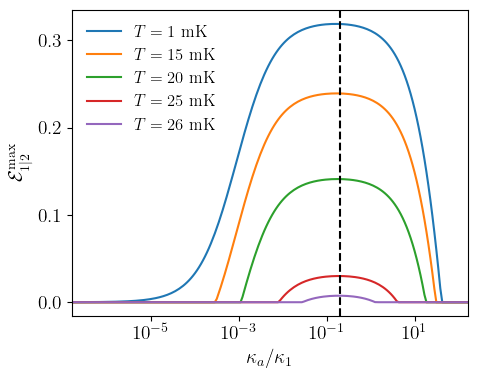

In [238]:
hbar=1.0545718*1e-34
kb=1.38064852*1e-23
N=1 #number of pinned DW/CSL modes
Nbins=201#number of bins for parameter variation
o10=2*np.pi*1e9#;o2=2*np.pi*1e9
o1=2*np.pi*1e9;o2=2*np.pi*1e9;oa=2*np.pi*1e12
kp1=0.001*o10;kp2=0.001*o10;kpa=0.002*o10
# kp1=0.0001*o1;kp2=0.0001*o1;kpa=0.1*o1
g1=-0.001*o10;g2=-0.001*o10
r=0.0;theta=0
eps=o1*1e-6;scale=1
T_vec=np.array([1,15,20,25,26])*1e-3
Delta_t=-o1*(40)
kpa_vec=np.logspace(0,9, Nbins)
E12_cut=np.zeros((3,len(kpa_vec)));E12_cut_max=np.zeros(len(kpa_vec))
Eab_cut=np.zeros((3,len(kpa_vec)));Eab_cut_max=np.zeros(len(kpa_vec))
squeezing12_cut=np.zeros((3,len(kpa_vec)));squeezing12_cut_min=np.zeros(len(kpa_vec))
squeezingab_cut=np.zeros((3,len(kpa_vec)));squeezingab_cut_min=np.zeros(len(kpa_vec))
W_res=np.zeros((len(T_vec),len(kpa_vec)))
# eigval_storer=np.zeros((6,3,len(kpa_vec)),dtype=np.complex128)
for iT,T in enumerate(T_vec):
    n_1th=1/np.expm1(hbar*o1/(kb*T))
    n_2th=1/np.expm1(hbar*o2/(kb*T))
    N0=0#1/np.expm1(hbar*oa/(kb*T))
    for ix,kpa in enumerate(kpa_vec):
        Omega=2*o1*g1*g1/(g1*g1*(o1**2 + kp1**2)) + 2*o2*g2*g2/(g1*g1*(o2**2 + kp2**2))
        G=np.sqrt( -(kpa**2 + Delta_t**2)/(2*Omega*Delta_t)) + eps;xi=np.sqrt((Delta_t**2 + kpa**2)*G*G)
        Delta=Delta_t-Omega*G*G
        D0=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) + 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
        D1=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) - 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
        D=np.zeros(6);D[0]=D0;D[1]=D1;D[2]=kp1*(2.0*n_1th+1.0);D[3]=kp1*(2.0*n_1th+1.0);D[4]=kp2*(2.0*n_2th+1.0);D[5]=kp2*(2.0*n_2th+1.0);D=np.diag(D)
        nas=np.array(root_evaluator(G,Delta_t,Omega));ns_1,ns_2,ns_3=nas
        alpha=1j*xi/(Delta_t + Omega*(nas-ns_1) + 1j*kpa)
        Delta=Delta_t - Omega*G*G
        a=1;b=2*Delta/(Omega);c=(Delta**2 + kpa**2)/(Omega**2);d=(-(xi/Omega)**2)
        p=[a,b,c,d];discriminant_temp=np.sign(( 4*(b**2 - 3*a*c)**3 - (2*b**3 - 9*a*b*c + 27*a*a*d)**2 )/(27*a*a))
        A[:,0,0]=-kpa*np.ones(3);A[:,0,1]=Delta+Omega*nas;A[:,0,2]=2*g1*np.imag(alpha)/g1;A[:,0,3]=np.zeros(3);A[:,0,4]=2*g2*np.imag(alpha)/g1;A[:,0,5]=np.zeros(3)
        A[:,1,0]=-A[:,0,1];A[:,1,1]=-kpa*np.ones(3);A[:,1,2]=2*g1*np.real(alpha)/g1;A[:,1,3]=np.zeros(3);A[:,1,4]=2*g2*np.real(alpha)/g1;A[:,1,5]=np.zeros(3)
        A[:,2,0]=np.zeros(3);A[:,2,1]=np.zeros(3);A[:,2,2]=-kp1*np.ones(3);A[:,2,3]=-o1*np.ones(3);A[:,2,4]=np.zeros(3);A[:,2,5]=np.zeros(3)
        A[:,3,0]=2*g1*np.real(alpha)/g1;A[:,3,1]=-2*g1*np.imag(alpha)/g1;A[:,3,2]=o1*np.ones(3);A[:,3,3]=-kp1*np.ones(3);A[:,3,4]=np.zeros(3);A[:,3,5]=np.zeros(3)
        A[:,4,0]=np.zeros(3);A[:,4,1]=np.zeros(3);A[:,4,2]=np.zeros(3);A[:,4,3]=np.zeros(3);A[:,4,4]=-kp2*np.ones(3);A[:,4,5]=-o2*np.ones(3)
        A[:,5,0]=2*g2*np.real(alpha)/g1;A[:,5,1]=-2*g2*np.imag(alpha)/g1;A[:,5,2]=np.zeros(3);A[:,5,3]=np.zeros(3);A[:,5,4]=o2*np.ones(3);A[:,5,5]=-kp2*np.ones(3)
        phaser_temp,Delta_d_temp,root_stability_temp,phaser1_temp=phase_gap_evaluator(nas,discriminant_temp,A)
        # for i in range(3):
        #     eigval_storer[:,i,ix]=-1j*np.linalg.eigvals(A[i,:,:])
        Eab_cut[:,ix],squeezingab_cut[:,ix],E12_cut[:,ix],squeezing12_cut[:,ix]=entanglement_finder(A,D)
        Eab_cut_max[ix]=np.max(np.real(Eab_cut[:,ix])*root_stability_temp);squeezingab_cut_min[ix]=np.max(np.real(squeezingab_cut[:,ix])*root_stability_temp)
        E12_cut_max[ix]=np.max(np.real(E12_cut[:,ix])*root_stability_temp);squeezing12_cut_min[ix]=np.max(np.real(squeezing12_cut[:,ix])*root_stability_temp)
    W_res[iT,:]=E12_cut_max

X=kpa_vec/kp1

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
for iT,T in enumerate(T_vec):
    axes.plot(X,W_res[iT,:],label=r'$T=%d$ mK' %(T/1e-3))
# plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=0.3,linestyle='dashed',color='black')
axes.set_xlabel(r'$\kappa_a/\kappa_1$')
axes.set_ylabel(r'$\mathcal{E}^{\rm{max}}_{1|2}$')
plt.xlim(X[0],X[-1])
plt.axvline(x=0.2,ls='--',color='black')
# plt.axhline(y=1/3,ls='--',color='black')
# plt.ylim(0,0.3)
plt.xscale('log')
# plt.yscale('log')
# axes.set_facecolor("black")
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.legend(frameon=False,fontsize=12)
# plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# plt.xlim(1e-4,1e1)
plt.tight_layout()
# plt.savefig("entangle_liner1.pdf", dpi=400)
plt.show()

# plt.figure(figsize=(5, 4))
# plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
# plt.rc('text', usetex=True)
# axes = plt.axes()
# # plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
# axes.plot(X,Ys1,color='red',label=r'$\omega_{1(2)}/\omega_0=1$')
# axes.plot(X,Ys1x,linestyle='dashed',color='green',label=r'$\omega_{1(2)}/\omega_0=10^2$')
# # axes.plot(X,Ys1xx,linestyle='dashdot',color='blue',label=r'$\kappa_{1(2)}=10$ MHz')
# # axes.plot(X,Ys1xxx,linestyle='dotted',color='brown',label=r'$\kappa_{a}=0.1$ MHz')
# # axes.plot(X,Ys,'-.',color='green',label=r'$\nu_{a,b_1}, -\tilde{\Delta}/\omega_1=1.2$')
# # plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=1/2,linestyle='dashed',color='black')
# axes.set_xlabel(r'$T$ (K)')
# axes.set_ylabel(r'$\nu^{\rm{min}}_{1|2}$')
# plt.xlim(X[0],X[-1])
# plt.ylim(0.24,0.6)
# plt.xscale('log')
# plt.legend(frameon=False,fontsize=14)
# # plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# # plt.yscale('log')
# # axes.set_facecolor("black")
# # plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# # plt.xlim(-1,0)
# plt.tight_layout()
# # plt.savefig("squeezing_liner.pdf", dpi=400)
# plt.show()

[]

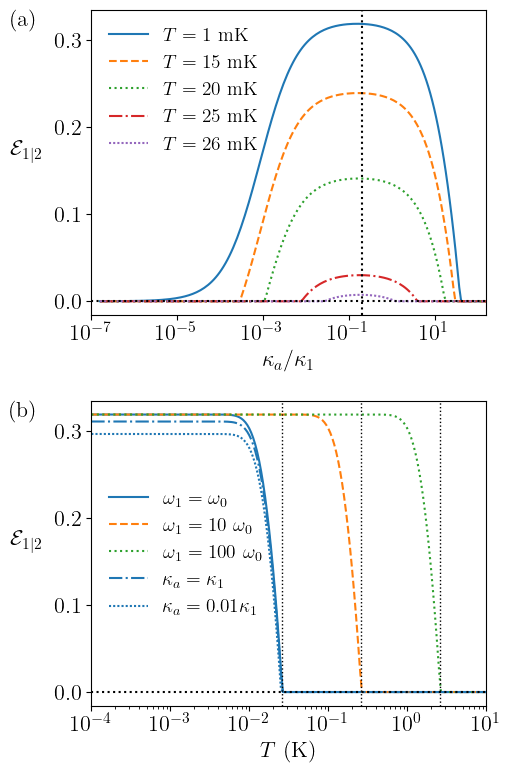

In [262]:
# Subplots environment for clubbing and labelling multiple figures
T_vec1=np.array([1,15,20,25,26])*1e-3
kpa_vec=np.logspace(0,9, Nbins)
T_vec=np.logspace(-4,1, Nbins)
o1_vec=np.array([1,10,100])*o10
import matplotlib.transforms as mtransforms
ncols=1;nrows=2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5, 8), sharex=False, sharey=False)#,layout="constrained"
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rc('text', usetex=True)
# add an artist, in this case a nice label in the middle...
label_list=['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']
ls_list=['solid','dashed','dotted','dashdot',(0, (1, 1)),(0, (5, 1)),(0, (3, 1, 1, 1))]
# axs[1].set_ylim(1e-38,1e-29)
for row in range(nrows):
    for col in range(ncols):
        trans = mtransforms.ScaledTranslation(-0.55, 0, fig.dpi_scale_trans)
        # axs[row].annotate(label_list[row], (0.5, 0.5),transform=axs[row].transAxes+trans,ha='center', va='center', fontsize=18,color='black')
        axs[row].text(-0.03, 1.0, label_list[col+row*ncols], transform=axs[row].transAxes + trans,
            fontsize='16', ha='center', va='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=0.0))
# Adjust the padding between subplots
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.12, top=0.9, wspace=0.1, hspace=0.1)
X=kpa_vec/kp1
for iT,T in enumerate(T_vec1):
    axs[0].plot(X,W_res[iT,:],ls=ls_list[iT],label=r'$T=%d$ mK' %(T/1e-3))
# plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=0.3,linestyle='dashed',color='black')
axs[0].set_xlabel(r'$\kappa_a/\kappa_1$')
axs[0].set_ylabel(r'$\mathcal{E}_{1|2}$', labelpad=20,rotation=0)
axs[0].set_xlim(X[0],X[-1])
axs[0].axvline(x=0.2,ls='dotted',color='black')
axs[0].axhline(y=0,ls='dotted',color='black')
axs[0].set_xticks([1e-7,1e-5,1e-3,1e-1,1e1])
# plt.ylim(0,0.3)
axs[0].set_xscale('log')
X1=T_vec
# axs[0].set_xlim(-parameter_vec[-1]/o1,-parameter_vec[0]/o1)
axs[1].plot(X1,W_res0[0,:],label=r'$\omega_1=\omega_0$')
for io1 in range(1,3):
    axs[1].plot(X1,W_res0[io1,:],ls=ls_list[io1],label=r'$\omega_1=%d~\omega_0$' %(o1_vec[io1]/o10))
axs[1].plot(X1,W_res0[3,:],ls=ls_list[3],color='tab:blue',label=r'$\kappa_a=\kappa_1$')
axs[1].plot(X1,W_res0[4,:],ls=ls_list[4],color='tab:blue',label=r'$\kappa_a=0.01\kappa_1$')
# plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=0.3,linestyle='dashed',color='black')
axs[1].set_xlabel(r'$T$ (K)')
axs[1].set_ylabel(r'$\mathcal{E}_{1|2}$', labelpad=20,rotation=0)
axs[1].set_xlim(X1[0],X1[-1])
axs[1].set_xscale('log')
axs[1].axhline(y=0,ls='dotted',color='black')
axs[1].axvline(x=26.3e-3,ls='dotted',lw=1,color='black')
axs[1].axvline(x=263e-3,ls='dotted',lw=1,color='black')
axs[1].axvline(x=2630e-3,ls='dotted',lw=1,color='black')
# plt.ylim(0,0.3)s[1,0].set_xscale('log')

# axs[0,0].set_ylim(0,5);axs[0,1].set_ylim(0,5);axs[1,0].set_ylim(0,5);axs[1,1].set_ylim(0,5)
# axs[1].set_facecolor("black")

# axs[2].set_yscale("log")
# axs[1].set_yscale("log")
# axs[0].set_xscale("log")
# axs[0].set_xticks([0.1,1,10,100])
axs[0].legend(prop={'weight': 'normal', "size": 14, 'stretch': 'normal'},frameon=False)#, labelcolor='white')
axs[1].legend(prop={'weight': 'normal', "size": 14, 'stretch': 'normal'},loc='center left',frameon=False)
# axs[0,1].legend(prop={'weight': 'normal', "size": 12, 'stretch': 'normal'},frameon=False)#, labelcolor='white')
# axs[1,1].legend(prop={'weight': 'normal', "size": 12, 'stretch': 'normal'},frameon=False)
# axs[1].legend(prop={'weight': 'normal', "size": 18, 'stretch': 'normal'},frameon=False, labelcolor='white')
# axs[2].legend(prop={'weight': 'normal', "size": 18, 'stretch': 'normal'},frameon=False, labelcolor='white')
# plt.tight_layout()
plt.subplots_adjust(left=0.18, right=0.97, top=0.97, bottom=0.1, hspace=0.28)
#plt.subplots_adjust(left=0.18, right=0.97, top=0.97, bottom=0.15, wspace=0.48, hspace=0.28)
plt.savefig("optimum_Ent.pdf",dpi=400)
plt.plot()

[]

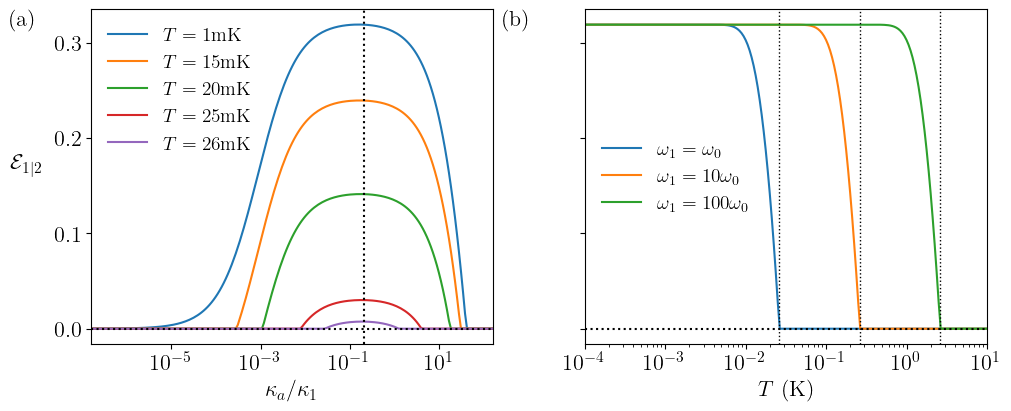

In [ ]:
# Subplots environment for clubbing and labelling multiple figures
T_vec1=np.array([1,15,20,25,26])*1e-3
kpa_vec=np.logspace(0,9, Nbins)
T_vec=np.logspace(-4,1, Nbins)
o1_vec=np.array([1,10,100])*o10
import matplotlib.transforms as mtransforms
ncols=2;nrows=1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 4), sharex=False, sharey=True,layout="constrained")
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rc('text', usetex=True)
# add an artist, in this case a nice label in the middle...
label_list=['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']
# axs[1].set_ylim(1e-38,1e-29)
for row in range(nrows):
    for col in range(ncols):
        trans = mtransforms.ScaledTranslation(-0.55, 0, fig.dpi_scale_trans)
        # axs[row].annotate(label_list[row], (0.5, 0.5),transform=axs[row].transAxes+trans,ha='center', va='center', fontsize=18,color='black')
        axs[col].text(-0.03, 1.0, label_list[col+row*ncols], transform=axs[col].transAxes + trans,
            fontsize='16', ha='center', va='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none', pad=0.0))
# Adjust the padding between subplots
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.12, top=0.9, wspace=0.1, hspace=0.1)
X=kpa_vec/kp1
for iT,T in enumerate(T_vec1):
    axs[0].plot(X,W_res[iT,:],label=r'$T=%d$mK' %(T/1e-3))
# plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=0.3,linestyle='dashed',color='black')
axs[0].set_xlabel(r'$\kappa_a/\kappa_1$')
axs[0].set_ylabel(r'$\mathcal{E}_{1|2}$', labelpad=20,rotation=0)
axs[0].set_xlim(X[0],X[-1])
axs[0].set_xticks([])
axs[0].axvline(x=0.2,ls='dotted',color='black')
axs[0].axhline(y=0,ls='dotted',color='black')
# plt.ylim(0,0.3)
axs[0].set_xscale('log')
X1=T_vec
# axs[0].set_xlim(-parameter_vec[-1]/o1,-parameter_vec[0]/o1)
axs[1].plot(X1,W_res0[0,:],label=r'$\omega_1=\omega_0$')
for io1 in range(1,len(o1_vec)):
    axs[1].plot(X1,W_res0[io1,:],label=r'$\omega_1=%d\omega_0$' %(o1_vec[io1]/o10))
# plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=0.3,linestyle='dashed',color='black')
axs[1].set_xlabel(r'$T$ (K)')
# axs[1].set_ylabel(r'$\mathcal{E}_{1|2}$', labelpad=20,rotation=0)
axs[1].set_xlim(X1[0],X1[-1])
axs[1].set_xscale('log')
axs[1].axhline(y=0,ls='dotted',color='black')
axs[1].axvline(x=26.3e-3,ls='dotted',lw=1,color='black')
axs[1].axvline(x=263e-3,ls='dotted',lw=1,color='black')
axs[1].axvline(x=2630e-3,ls='dotted',lw=1,color='black')
# plt.ylim(0,0.3)s[1,0].set_xscale('log')

# axs[0,0].set_ylim(0,5);axs[0,1].set_ylim(0,5);axs[1,0].set_ylim(0,5);axs[1,1].set_ylim(0,5)
# axs[1].set_facecolor("black")

# axs[2].set_yscale("log")
# axs[1].set_yscale("log")
# axs[0].set_xscale("log")
# axs[0].set_xticks([0.1,1,10,100])
axs[0].legend(prop={'weight': 'normal', "size": 14, 'stretch': 'normal'},frameon=False)#, labelcolor='white')
axs[1].legend(prop={'weight': 'normal', "size": 14, 'stretch': 'normal'},frameon=False)
# axs[0,1].legend(prop={'weight': 'normal', "size": 12, 'stretch': 'normal'},frameon=False)#, labelcolor='white')
# axs[1,1].legend(prop={'weight': 'normal', "size": 12, 'stretch': 'normal'},frameon=False)
# axs[1].legend(prop={'weight': 'normal', "size": 18, 'stretch': 'normal'},frameon=False, labelcolor='white')
# axs[2].legend(prop={'weight': 'normal', "size": 18, 'stretch': 'normal'},frameon=False, labelcolor='white')
# plt.tight_layout()
# plt.subplots_adjust(left=0.15, right=0.97, top=0.97, bottom=0.15, wspace=0.48, hspace=0.18)
# plt.savefig("optimum_Ent.pdf",dpi=400)
plt.plot()

In [ ]:
np.savetxt("E_vs_kpa_data.txt",np.c_[kpa_vec/kp1,W_res[:]])

In [ ]:
hbar=1.0545718*1e-34
kb=1.38064852*1e-23
N=1 #number of pinned DW/CSL modes
Nbins=201#number of bins for parameter variation
o10=2*np.pi*1e9#;o2=2*np.pi*1e9
o1=2*np.pi*1e9;o2=2*np.pi*1e9;oa=2*np.pi*1e12
kp1=0.001*o10;kp2=0.001*o10;kpa=0.002*o10
# kp1=0.0001*o1;kp2=0.0001*o1;kpa=0.1*o1
g1=-0.001*o10;g2=-0.001*o10
T=26e-3
n_1th=1/np.expm1(hbar*o1/(kb*T))
n_2th=1/np.expm1(hbar*o2/(kb*T))
N0=1/np.expm1(hbar*oa/(kb*T))
r=0.0;theta=0
eps=o1*1e-6;scale=1
# T_vec=np.logspace(-4,3, Nbins)
kpa_vec=np.logspace(3,9, Nbins)

E12_cut=np.zeros((3,len(T_vec)));E12_cut_max=np.zeros(len(T_vec))
Eab_cut=np.zeros((3,len(T_vec)));Eab_cut_max=np.zeros(len(T_vec))
squeezing12_cut=np.zeros((3,len(T_vec)));squeezing12_cut_min=np.zeros(len(T_vec))
squeezingab_cut=np.zeros((3,len(T_vec)));squeezingab_cut_min=np.zeros(len(T_vec))
for ix,kpa in enumerate(kpa_vec):
    Omega=2*o1*g1*g1/(g1*g1*(o1**2 + kp1**2)) + 2*o2*g2*g2/(g1*g1*(o2**2 + kp2**2))
    for iy,Delta_t in enumerate(Delta_t_vec):
        G=np.sqrt( -(kpa**2 + Delta_t**2)/(2*Omega*Delta_t)) + eps;xi=np.sqrt((Delta_t**2 + kpa**2)*G*G)
        Delta=Delta_t-Omega*G*G;print(Delta/o1,Delta_t/o1)
        n_1th=1/np.expm1(hbar*o1/(kb*T))
        n_2th=1/np.expm1(hbar*o2/(kb*T))
        D0=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) + 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
        D1=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) - 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
        D=np.zeros(6);D[0]=D0;D[1]=D1;D[2]=kp1*(2.0*n_1th+1.0);D[3]=kp1*(2.0*n_1th+1.0);D[4]=kp2*(2.0*n_2th+1.0);D[5]=kp2*(2.0*n_2th+1.0);D=np.diag(D)
        nas=np.array(root_evaluator(G,Delta_t,Omega));ns_1,ns_2,ns_3=nas
        alpha=1j*xi/(Delta_t + Omega*(nas-ns_1) + 1j*kpa)
        Delta=Delta_t - Omega*G*G
        a=1;b=2*Delta/(Omega);c=(Delta**2 + kpa**2)/(Omega**2);d=(-(xi/Omega)**2)
        p=[a,b,c,d];discriminant_temp=np.sign(( 4*(b**2 - 3*a*c)**3 - (2*b**3 - 9*a*b*c + 27*a*a*d)**2 )/(27*a*a))
        A[:,0,0]=-kpa*np.ones(3);A[:,0,1]=Delta+Omega*nas;A[:,0,2]=2*g1*np.imag(alpha)/g1;A[:,0,3]=np.zeros(3);A[:,0,4]=2*g2*np.imag(alpha)/g1;A[:,0,5]=np.zeros(3)
        A[:,1,0]=-A[:,0,1];A[:,1,1]=-kpa*np.ones(3);A[:,1,2]=2*g1*np.real(alpha)/g1;A[:,1,3]=np.zeros(3);A[:,1,4]=2*g2*np.real(alpha)/g1;A[:,1,5]=np.zeros(3)
        A[:,2,0]=np.zeros(3);A[:,2,1]=np.zeros(3);A[:,2,2]=-kp1*np.ones(3);A[:,2,3]=-o1*np.ones(3);A[:,2,4]=np.zeros(3);A[:,2,5]=np.zeros(3)
        A[:,3,0]=2*g1*np.real(alpha)/g1;A[:,3,1]=-2*g1*np.imag(alpha)/g1;A[:,3,2]=o1*np.ones(3);A[:,3,3]=-kp1*np.ones(3);A[:,3,4]=np.zeros(3);A[:,3,5]=np.zeros(3)
        A[:,4,0]=np.zeros(3);A[:,4,1]=np.zeros(3);A[:,4,2]=np.zeros(3);A[:,4,3]=np.zeros(3);A[:,4,4]=-kp2*np.ones(3);A[:,4,5]=-o2*np.ones(3)
        A[:,5,0]=2*g2*np.real(alpha)/g1;A[:,5,1]=-2*g2*np.imag(alpha)/g1;A[:,5,2]=np.zeros(3);A[:,5,3]=np.zeros(3);A[:,5,4]=o2*np.ones(3);A[:,5,5]=-kp2*np.ones(3)
        phaser_temp,Delta_d_temp,root_stability_temp,phaser1_temp=phase_gap_evaluator(nas,discriminant_temp,A)
        Eab_cut[:,ix],squeezingab_cut[:,ix],E12_cut[:,ix],squeezing12_cut[:,ix]=entanglement_finder(A,D)
        Eab_cut_max[ix]=np.max(np.real(Eab_cut[:,ix])*root_stability_temp);squeezingab_cut_min[ix]=np.max(np.real(squeezingab_cut[:,ix])*root_stability_temp)
        E12_cut_max[ix]=np.max(np.real(E12_cut[:,ix])*root_stability_temp);squeezing12_cut_min[ix]=np.max(np.real(squeezing12_cut[:,ix])*root_stability_temp)

X=kpa_vec/kp1
# Y=Eab_cut_max;Ys=squeezingab_cut_min
# W1=E12_cut_max;Ys1=squeezing12_cut_min
# W1x=E12_cut_max;Ys1x=squeezing12_cut_min
W1xx=E12_cut_max;Ys1xx=squeezing12_cut_min
# Y1xxx=E12_cut_max;Ys1xxx=squeezing12_cut_min

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
axes.plot(X,W1,color='red',label=r'$\omega_{1(2)}=\omega_0$')
axes.plot(X,W1x,linestyle='dashed',color='green',label=r'$\omega_{1(2)}=10\omega_0$')
axes.plot(X,W1xx,linestyle='dashdot',color='blue',label=r'$\omega_{1(2)}=10^2\omega_0$')
# axes.plot(X,Y1xxx,linestyle='dotted',color='brown',label=r'$10\kappa_a=\kappa_{a0}$')
# axes.plot(X,Y,'-.',color='green',label=r'$E_{a,b_1},\\ -\tilde{\Delta}/\omega_1=1.2$')
# plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=0.3,linestyle='dashed',color='black')
axes.set_xlabel(r'$\kappa_a/\kappa_1$')
axes.set_ylabel(r'$\mathcal{E}^{\rm{max}}_{1|2}$')
plt.xlim(X[0],X[-1])
plt.axvline(x=0.2,ls='--',color='black')
plt.axhline(y=1/3,ls='--',color='black')
# plt.ylim(0,0.3)
plt.xscale('log')
plt.yscale('log')
# axes.set_facecolor("black")
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
plt.legend(frameon=False,fontsize=13)
# plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# plt.xlim(1e-4,1e1)
plt.tight_layout()
# plt.savefig("entangle_liner1.pdf", dpi=400)
plt.show()

# plt.figure(figsize=(5, 4))
# plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
# plt.rc('text', usetex=True)
# axes = plt.axes()
# # plt.colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$', fontsize=20)
# axes.plot(X,Ys1,color='red',label=r'$\omega_{1(2)}/\omega_0=1$')
# axes.plot(X,Ys1x,linestyle='dashed',color='green',label=r'$\omega_{1(2)}/\omega_0=10^2$')
# # axes.plot(X,Ys1xx,linestyle='dashdot',color='blue',label=r'$\kappa_{1(2)}=10$ MHz')
# # axes.plot(X,Ys1xxx,linestyle='dotted',color='brown',label=r'$\kappa_{a}=0.1$ MHz')
# # axes.plot(X,Ys,'-.',color='green',label=r'$\nu_{a,b_1}, -\tilde{\Delta}/\omega_1=1.2$')
# # plt.axvline(x=1,linestyle='dashed',color='black')
# plt.axhline(y=1/2,linestyle='dashed',color='black')
# axes.set_xlabel(r'$T$ (K)')
# axes.set_ylabel(r'$\nu^{\rm{min}}_{1|2}$')
# plt.xlim(X[0],X[-1])
# plt.ylim(0.24,0.6)
# plt.xscale('log')
# plt.legend(frameon=False,fontsize=14)
# # plt.xticks([1e-1,1,1e1,1e2,1e3,1e4])
# # plt.yscale('log')
# # axes.set_facecolor("black")
# # plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# # plt.xlim(-1,0)
# plt.tight_layout()
# # plt.savefig("squeezing_liner.pdf", dpi=400)
# plt.show()

In [20]:
hbar=1.0545718*1e-34
kb=1.38064852*1e-23
N=1 #number of pinned DW/CSL modes
Nbins=201#number of bins for parameter variation
o1=2*np.pi*1e9;o2=2*np.pi*1e9;oa=2*np.pi*1e12
kp1=0.001*o1;kp2=0.001*o1;kpa=0.002*o1
# kp1=0.0001*o1;kp2=0.0001*o1;kpa=0.1*o1
g1=-0.001*o1;g2=-0.001*o1
T=2e-3
n_1th=1/np.expm1(hbar*o1/(kb*T))
n_2th=1/np.expm1(hbar*o2/(kb*T))
N0=1/np.expm1(hbar*oa/(kb*T))
r=0.0;theta=np.pi;phi=np.pi/2

Delta_t_vec=-np.logspace(2,-2,Nbins)*o1
G12_vec=np.sqrt( -(kpa**2 + Delta_t_vec**2)/(2*Omega*Delta_t_vec))
T_vec=np.logspace(-4,-1,Nbins)

E12_cut=np.zeros((3,len(Delta_t_vec),len(T_vec)));E12_cut_max=np.zeros((len(Delta_t_vec),len(T_vec)))
Eab_cut=np.zeros((3,len(Delta_t_vec),len(T_vec)));Eab_cut_max=np.zeros((len(Delta_t_vec),len(T_vec)))
squeezing12_cut=np.zeros((3,len(Delta_t_vec),len(T_vec)));squeezing12_cut_min=np.zeros((len(Delta_t_vec),len(T_vec)))
squeezingab_cut=np.zeros((3,len(Delta_t_vec),len(T_vec)));squeezingab_cut_min=np.zeros((len(Delta_t_vec),len(T_vec)))
eps=o1*1e-6;scale=1
D0=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) + 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
D1=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) - 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
Omega=2*o1*g1*g1/(g1*g1*(o1**2 + kp1**2)) + 2*o2*g2*g2/(g1*g1*(o2**2 + kp2**2))
for ix,T in enumerate(T_vec):
    n_1th=1/np.expm1(hbar*o1/(kb*T))
    n_2th=1/np.expm1(hbar*o2/(kb*T))
    D=np.zeros(6);D[0]=D0;D[1]=D1;D[2]=kp1*(2.0*n_1th+1.0);D[3]=kp1*(2.0*n_1th+1.0);D[4]=kp2*(2.0*n_2th+1.0);D[5]=kp2*(2.0*n_2th+1.0);D=np.diag(D)
    for iy,Delta_t in enumerate(Delta_t_vec):
        G=G12_vec[iy]+eps
        xi=np.sqrt((Delta_t**2 + kpa**2)*G*G)
        nas=np.array(root_evaluator(G,Delta_t,Omega));ns_1,ns_2,ns_3=nas
        alpha=1j*xi/(Delta_t + Omega*(nas-ns_1) + 1j*kpa)
        Delta=Delta_t - Omega*G*G
        a=1;b=2*Delta/(Omega);c=(Delta**2 + kpa**2)/(Omega**2);d=(-(xi/Omega)**2)
        p=[a,b,c,d];discriminant_temp=np.sign(( 4*(b**2 - 3*a*c)**3 - (2*b**3 - 9*a*b*c + 27*a*a*d)**2 )/(27*a*a))
        A[:,0,0]=-kpa*np.ones(3);A[:,0,1]=Delta+Omega*nas;A[:,0,2]=2*g1*np.imag(alpha)/g1;A[:,0,3]=np.zeros(3);A[:,0,4]=2*g2*np.imag(alpha)/g1;A[:,0,5]=np.zeros(3)
        A[:,1,0]=-A[:,0,1];A[:,1,1]=-kpa*np.ones(3);A[:,1,2]=2*g1*np.real(alpha)/g1;A[:,1,3]=np.zeros(3);A[:,1,4]=2*g2*np.real(alpha)/g1;A[:,1,5]=np.zeros(3)
        A[:,2,0]=np.zeros(3);A[:,2,1]=np.zeros(3);A[:,2,2]=-kp1*np.ones(3);A[:,2,3]=-o1*np.ones(3);A[:,2,4]=np.zeros(3);A[:,2,5]=np.zeros(3)
        A[:,3,0]=2*g1*np.real(alpha)/g1;A[:,3,1]=-2*g1*np.imag(alpha)/g1;A[:,3,2]=o1*np.ones(3);A[:,3,3]=-kp1*np.ones(3);A[:,3,4]=np.zeros(3);A[:,3,5]=np.zeros(3)
        A[:,4,0]=np.zeros(3);A[:,4,1]=np.zeros(3);A[:,4,2]=np.zeros(3);A[:,4,3]=np.zeros(3);A[:,4,4]=-kp2*np.ones(3);A[:,4,5]=-o2*np.ones(3)
        A[:,5,0]=2*g2*np.real(alpha)/g1;A[:,5,1]=-2*g2*np.imag(alpha)/g1;A[:,5,2]=np.zeros(3);A[:,5,3]=np.zeros(3);A[:,5,4]=o2*np.ones(3);A[:,5,5]=-kp2*np.ones(3)
        phaser_temp,Delta_d_temp,root_stability_temp,phaser1_temp=phase_gap_evaluator(nas,discriminant_temp,A)
        Eab_cut[:,iy,ix],squeezingab_cut[:,iy,ix],E12_cut[:,iy,ix],squeezing12_cut[:,iy,ix]=entanglement_finder(A,D)
        Eab_cut_max[iy,ix]=np.max(np.real(Eab_cut[:,iy,ix])*root_stability_temp);squeezingab_cut_min[iy,ix]=np.min(np.real(squeezingab_cut[:,iy,ix]*root_stability_temp + 10*(1-root_stability_temp)))
        E12_cut_max[iy,ix]=np.max(np.real(E12_cut[:,iy,ix])*root_stability_temp);squeezing12_cut_min[iy,ix]=np.min(np.real(squeezing12_cut[:,iy,ix]*root_stability_temp + 10*(1-root_stability_temp)))

print("Calculations Completed")

/tmp/ipykernel_41259/1267047099.py:12: RuntimeWarning: overflow encountered in expm1
  N0=1/np.expm1(hbar*oa/(kb*T))


Calculations Completed


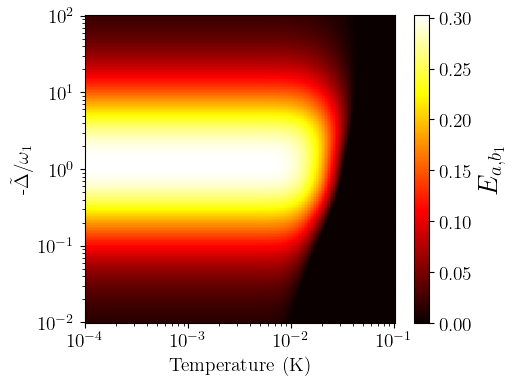

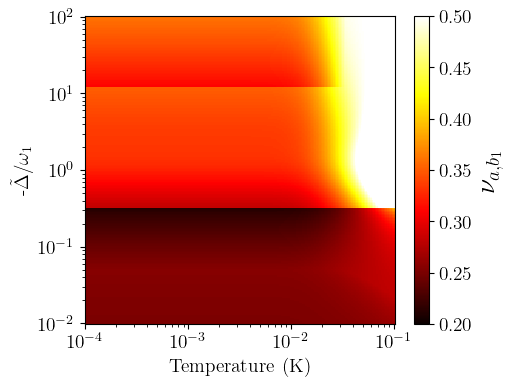

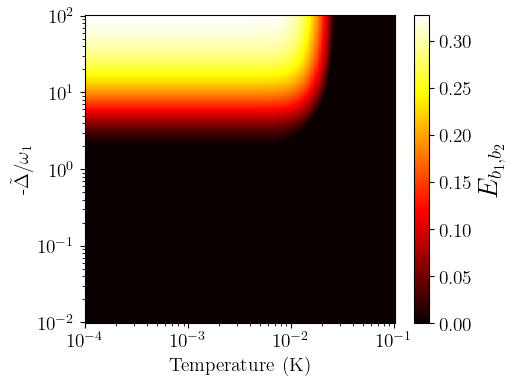

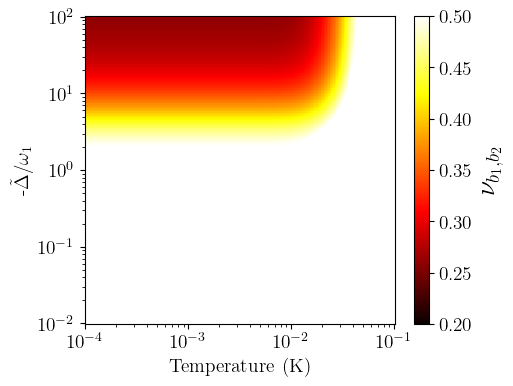

In [21]:
X=T_vec
Y=-Delta_t_vec/o1
Z=Eab_cut_max;Z1=E12_cut_max
Zs=squeezingab_cut_min;Zs1=squeezing12_cut_min

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z, cmap='hot', shading='nearest')#,vmin=0,vmax=0.3)#,vmin=0.2,vmax=0.5)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$E_{a,b_1}$', fontsize=20)
# axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
# axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
# axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_ylabel(r'-$\tilde{\Delta}/\omega_1$')
axes.set_xlabel(r'Temperature (K)')
axes.set_facecolor("black")
plt.xscale('log');plt.yscale('log')
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

X=T_vec
Y=-Delta_t_vec/o1

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Zs, cmap='hot', shading='nearest',vmin=0.2,vmax=0.5)#,vmin=0.2,vmax=0.5)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$\nu_{a,b_1}$', fontsize=20)
# axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
# axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
# axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_ylabel(r'-$\tilde{\Delta}/\omega_1$')
axes.set_xlabel(r'Temperature (K)')
axes.set_facecolor("black")
plt.xscale('log');plt.yscale('log')
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

X=T_vec
Y=-Delta_t_vec/o1

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z1, cmap='hot', shading='nearest')#,vmin=0,vmax=0.3)#,vmin=0.2,vmax=0.5)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$E_{b_1,b_2}$', fontsize=20)
# axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
# axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
# axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_ylabel(r'-$\tilde{\Delta}/\omega_1$')
axes.set_xlabel(r'Temperature (K)')
axes.set_facecolor("black")
plt.xscale('log');plt.yscale('log')
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

X=T_vec
Y=-Delta_t_vec/o1

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Zs1, cmap='hot', shading='nearest',vmin=0.2,vmax=0.5)#,vmin=0.2,vmax=0.5)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$\nu_{b_1,b_2}$', fontsize=20)
# axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
# axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
# axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_ylabel(r'-$\tilde{\Delta}/\omega_1$')
axes.set_xlabel(r'Temperature (K)')
axes.set_facecolor("black")
plt.xscale('log');plt.yscale('log')
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

[]

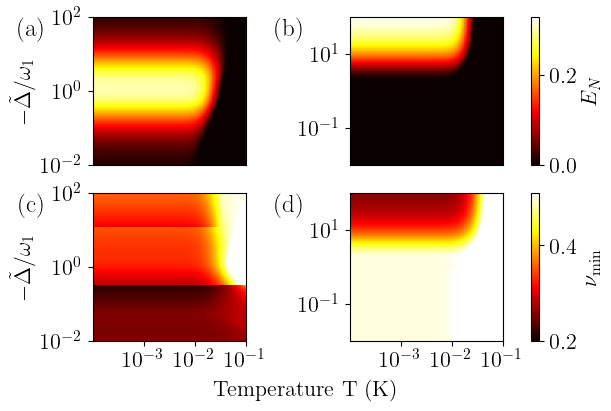

In [64]:
X=T_vec
Y=-Delta_t_vec/o1
X0=X
Y0=Y
X,Y = np.meshgrid(X,Y)
# Subplots environment for clubbing and labelling multiple figures
import matplotlib.transforms as mtransforms
ncols=2;nrows=2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6, 4),layout="constrained", sharex=False)#, sharey=True);,layout="constrained"
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rc('text', usetex=True)
# add an artist, in this case a nice label in the middle...
label_list=['(a)','(b)','(c)','(d)','(e)','(f)','(g)']
# axs[1].set_ylim(1e-38,1e-29)
for row in range(nrows):
    for col in range(ncols):
        trans = mtransforms.ScaledTranslation(-0.6, 0, fig.dpi_scale_trans)
        # axs[row].annotate(label_list[row], (0.5, 0.5),transform=axs[row].transAxes+trans,ha='center', va='center', fontsize=14,color='black')
        axs[row,col].text(0.0, 1.0, label_list[col+row*ncols], transform=axs[row,col].transAxes + trans,
            fontsize='18', ha='center', va='top', fontfamily='serif',
            bbox=dict(facecolor='1', edgecolor='none', pad=0.2))
# Adjust the padding between subplots
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.12, top=0.9, wspace=0.1, hspace=0.1)

axs[0,0].pcolormesh(X,Y,Z, cmap='hot', shading='nearest',vmin=0,vmax=0.33)#,norm=colors.LogNorm(vmin=1,vmax=1e8))
# axs[0,0].plot(X0,Gp1,'--',color='green')
# axs[0,0].plot(X0,G23p1,'--',color='aquamarine')
axs[0,0].set_xscale("log")
axs[0,0].set_yscale("log")

im1=axs[0,1].pcolormesh(X,Y,Z1, cmap='hot', shading='nearest',vmin=0,vmax=0.33)#,norm=colors.LogNorm(vmin=1,vmax=1e8))
# axs[0,1].colorbar(im, ax=axes).set_label(r'$E^{\rm max}_N$')#, fontsize=18)
fig.colorbar(im1, ax=axs[0,1]).set_label(r'$E_N$')#, fontsize=14)
# axs[0,1].plot(X0,Gp1,'--',color='blue')
# axs[0,1].plot(X0,G23p1,'--',color='aquamarine')
axs[0,1].set_xscale("log")
axs[0,1].set_yscale("log")

axs[1,0].pcolormesh(X,Y,Zs, cmap='hot', shading='nearest',vmin=0.2,vmax=0.51)#,norm=colors.LogNorm(vmin=1,vmax=1e8))
# axs[1,0].plot(X0,Gp1,'--',color='green')
# axs[1,0].plot(X0,G23p1,'--',color='aquamarine')
axs[1,0].set_xscale("log")
axs[1,0].set_yscale("log")

im2=axs[1,1].pcolormesh(X,Y,Zs1, cmap='hot', shading='nearest',vmin=0.2,vmax=0.51)#,norm=colors.LogNorm(vmin=1,vmax=1e8))
# axs[1,1].colorbar(im, ax=axes).set_label(r'$\nu_{\rm min}$')
fig.colorbar(im2, ax=axs[1,1]).set_label(r'$\nu_{\rm min}$')#, fontsize=14)
# axs[1,1].plot(X0,Gp1,'--',color='blue')
# axs[1,1].plot(X0,G23p1,'--',color='aquamarine')
axs[1,1].set_xscale("log")
axs[1,1].set_yscale("log")


# axs[0].set_xlim(-parameter_vec[-1]/o1,-parameter_vec[0]/o1)
# axs[2].set_ylim(o_vec[0]/o1,o_vec[-1]/o1)
# axs[1].set_ylim(o_vec[0]/o1,o_vec[-1]/o1)
# axs[0].set_ylim(o_vec[0]/o1,o_vec[-1]/o1)
# axs[1,0].set_xlabel(r'Temperature T (K)')
# axs[1,1].set_xlabel(r'Temperature T (K)')
axs[0,0].set_ylabel(r'$-\tilde{\Delta}/\omega_1$')
axs[1,0].set_ylabel(r'$-\tilde{\Delta}/\omega_1$')
fig.supxlabel(r'Temperature T (K)', fontsize=16)
axs[0,0].set_xticks([])
axs[0,1].set_xticks([])
axs[1,0].set_xticks([1e-3,1e-2,1e-1])
axs[1,1].set_xticks([1e-3,1e-2,1e-1])
axs[0,0].set_yticks([1e-2,1,1e2])
axs[1,0].set_yticks([1e-2,1,1e2])
# axs[0,2].set_xlim(1e-4,1e2)
# axs[1,2].set_xlim(1e-4,1e2)
# axs[0,2].set_ylim(0,0.33)
# axs[1,2].set_ylim(0.2,0.51)
# axs[1].set_facecolor("black")

# axs[2].set_yscale("log")
# axs[1].set_yscale("log")
# axs[0].set_xscale("log")
# axs[0].set_xticks([0.1,1,10,100])
# axs[0,2].legend(prop={'weight': 'normal', "size": 20, 'stretch': 'normal'},frameon=False)#, labelcolor='white')
# axs[1,2].legend(prop={'weight': 'normal', "size": 20, 'stretch': 'normal'},frameon=False)
# axs[1].legend(prop={'weight': 'normal', "size": 14, 'stretch': 'normal'},frameon=False, labelcolor='white')
# axs[2].legend(prop={'weight': 'normal', "size": 14, 'stretch': 'normal'},frameon=False, labelcolor='white')
# plt.tight_layout()
plt.savefig("temp_colormap.png",dpi=400)
plt.plot()

In [29]:
hbar=1.0545718*1e-34
kb=1.38064852*1e-23
N=1 #number of pinned DW/CSL modes
Nbins=201#number of bins for parameter variation
o1=2*np.pi*1e9;o2=2*np.pi*1e9;oa=2*np.pi*1e12
kp1=0.001*o1;kp2=0.001*o1;kpa=0.002*o1
# kp1=0.0001*o1;kp2=0.0001*o1;kpa=0.1*o1
g1=-0.001*o1;g2=-0.001*o1
T=2e-3
n_1th=1/np.expm1(hbar*o1/(kb*T))
n_2th=1/np.expm1(hbar*o2/(kb*T))
N0=1/np.expm1(hbar*oa/(kb*T))
r=0.3;theta=0

# o_vec=-np.logspace(2,-2,Nbins)*o1
Delta_t=-40*o1
o_vec=np.logspace(0,4)*o1
# G12_vec=np.sqrt( -(kpa**2 + Delta_t_vec**2)/(2*Omega*Delta_t_vec))
T_vec=np.logspace(-3,3,Nbins)

E12_cut=np.zeros((3,len(o_vec),len(T_vec)));E12_cut_max=np.zeros((len(o_vec),len(T_vec)))
Eab_cut=np.zeros((3,len(o_vec),len(T_vec)));Eab_cut_max=np.zeros((len(o_vec),len(T_vec)))
squeezing12_cut=np.zeros((3,len(o_vec),len(T_vec)));squeezing12_cut_min=np.zeros((len(o_vec),len(T_vec)))
squeezingab_cut=np.zeros((3,len(o_vec),len(T_vec)));squeezingab_cut_min=np.zeros((len(o_vec),len(T_vec)))
eps=o1*1e-6;scale=1
D0=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) + 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
D1=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) - 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
Omega=2*o1*g1*g1/(g1*g1*(o1**2 + kp1**2)) + 2*o2*g2*g2/(g1*g1*(o2**2 + kp2**2))
for ix,T in enumerate(T_vec):
    for iy,o1 in enumerate(o_vec):
        o2=o1
        Omega=2*o1*g1*g1/(g1*g1*(o1**2 + kp1**2)) + 2*o2*g2*g2/(g1*g1*(o2**2 + kp2**2))
        n_1th=1/np.expm1(hbar*o1/(kb*T))
        n_2th=1/np.expm1(hbar*o2/(kb*T))
        N0=1/np.expm1(hbar*oa/(kb*T))
        D0=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) + 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
        D1=2*kpa*np.sinh(r)**2 + kpa*(2*N0*(np.sinh(r)**2 + np.cosh(r)**2) + 1) - 2.*kpa*np.sinh(r)*np.cosh(r)*(1+2*N0)
        D=np.zeros(6);D[0]=D0;D[1]=D1;D[2]=kp1*(2.0*n_1th+1.0);D[3]=kp1*(2.0*n_1th+1.0);D[4]=kp2*(2.0*n_2th+1.0);D[5]=kp2*(2.0*n_2th+1.0);D=np.diag(D)
        Delta_t=-40*o1
        G=np.sqrt( -(kpa**2 + Delta_t**2)/(2*Omega*Delta_t))+eps
        xi=np.sqrt((Delta_t**2 + kpa**2)*G*G)
        nas=np.array(root_evaluator(G,Delta_t,Omega));ns_1,ns_2,ns_3=nas
        alpha=1j*xi/(Delta_t + Omega*(nas-ns_1) + 1j*kpa)
        Delta=Delta_t - Omega*G*G
        a=1;b=2*Delta/(Omega);c=(Delta**2 + kpa**2)/(Omega**2);d=(-(xi/Omega)**2)
        p=[a,b,c,d];discriminant_temp=np.sign(( 4*(b**2 - 3*a*c)**3 - (2*b**3 - 9*a*b*c + 27*a*a*d)**2 )/(27*a*a))
        A[:,0,0]=-kpa*np.ones(3);A[:,0,1]=Delta+Omega*nas;A[:,0,2]=2*g1*np.imag(alpha)/g1;A[:,0,3]=np.zeros(3);A[:,0,4]=2*g2*np.imag(alpha)/g1;A[:,0,5]=np.zeros(3)
        A[:,1,0]=-A[:,0,1];A[:,1,1]=-kpa*np.ones(3);A[:,1,2]=2*g1*np.real(alpha)/g1;A[:,1,3]=np.zeros(3);A[:,1,4]=2*g2*np.real(alpha)/g1;A[:,1,5]=np.zeros(3)
        A[:,2,0]=np.zeros(3);A[:,2,1]=np.zeros(3);A[:,2,2]=-kp1*np.ones(3);A[:,2,3]=-o1*np.ones(3);A[:,2,4]=np.zeros(3);A[:,2,5]=np.zeros(3)
        A[:,3,0]=2*g1*np.real(alpha)/g1;A[:,3,1]=-2*g1*np.imag(alpha)/g1;A[:,3,2]=o1*np.ones(3);A[:,3,3]=-kp1*np.ones(3);A[:,3,4]=np.zeros(3);A[:,3,5]=np.zeros(3)
        A[:,4,0]=np.zeros(3);A[:,4,1]=np.zeros(3);A[:,4,2]=np.zeros(3);A[:,4,3]=np.zeros(3);A[:,4,4]=-kp2*np.ones(3);A[:,4,5]=-o2*np.ones(3)
        A[:,5,0]=2*g2*np.real(alpha)/g1;A[:,5,1]=-2*g2*np.imag(alpha)/g1;A[:,5,2]=np.zeros(3);A[:,5,3]=np.zeros(3);A[:,5,4]=o2*np.ones(3);A[:,5,5]=-kp2*np.ones(3)
        phaser_temp,Delta_d_temp,root_stability_temp,phaser1_temp=phase_gap_evaluator(nas,discriminant_temp,A)
        Eab_cut[:,iy,ix],squeezingab_cut[:,iy,ix],E12_cut[:,iy,ix],squeezing12_cut[:,iy,ix]=entanglement_finder(A,D)
        Eab_cut_max[iy,ix]=np.max(np.real(Eab_cut[:,iy,ix])*root_stability_temp);squeezingab_cut_min[iy,ix]=np.min(np.real(squeezingab_cut[:,iy,ix]*root_stability_temp + 10*(1-root_stability_temp)))
        E12_cut_max[iy,ix]=np.max(np.real(E12_cut[:,iy,ix])*root_stability_temp);squeezing12_cut_min[iy,ix]=np.min(np.real(squeezing12_cut[:,iy,ix]*root_stability_temp + 10*(1-root_stability_temp)))

print("Calculations Completed")

/tmp/ipykernel_134838/1331281760.py:12: RuntimeWarning: overflow encountered in expm1
  N0=1/np.expm1(hbar*oa/(kb*T))
/tmp/ipykernel_134838/1331281760.py:35: RuntimeWarning: overflow encountered in expm1
  N0=1/np.expm1(hbar*oa/(kb*T))
/tmp/ipykernel_134838/1331281760.py:33: RuntimeWarning: overflow encountered in expm1
  n_1th=1/np.expm1(hbar*o1/(kb*T))
/tmp/ipykernel_134838/1331281760.py:34: RuntimeWarning: overflow encountered in expm1
  n_2th=1/np.expm1(hbar*o2/(kb*T))


Calculations Completed


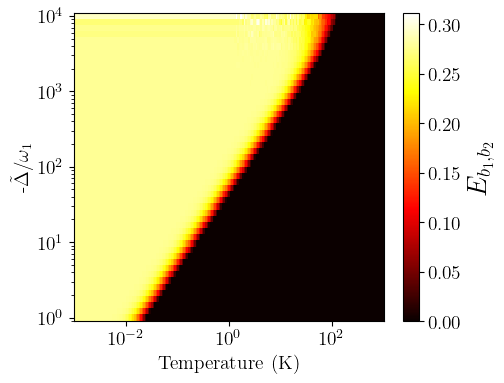

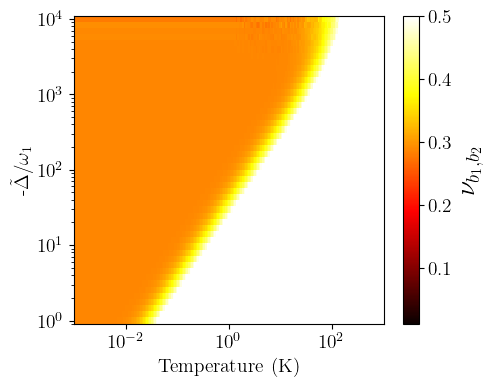

In [30]:
X=T_vec
Y=o_vec/(2*np.pi*1e9)
Z=Eab_cut_max;Z1=E12_cut_max
Zs=squeezingab_cut_min;Zs1=squeezing12_cut_min

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Z1, cmap='hot', shading='nearest')#,vmin=0,vmax=0.3)#,vmin=0.2,vmax=0.5)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$E_{b_1,b_2}$', fontsize=20)
# axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
# axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
# axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_ylabel(r'-$\tilde{\Delta}/\omega_1$')
axes.set_xlabel(r'Temperature (K)')
axes.set_facecolor("black")
plt.xscale('log');plt.yscale('log')
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

X=T_vec
Y=o_vec/(2*np.pi*1e9)

plt.figure(figsize=(5, 4))
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':14})
plt.rc('text', usetex=True)
axes = plt.axes()
# axes.plot(Xd,5*np.ones(len(Xd)),'--',color='red')
# plt.axvline(x=0.2, color="green", linestyle="--")
X,Y = np.meshgrid(X,Y)
im = axes.pcolormesh(X,Y,Zs1, cmap='hot', shading='nearest',vmin=0.01,vmax=0.5)#,vmin=0.2,vmax=0.5)
#fig.colorbar(im, ax=axes, ticks=np.arange(10000)).set_label(r'$\frac{\zeta_{opt}(r=0,\theta=0)}{\zeta_{opt}(r,\theta)}$', fontsize=20)
plt.colorbar(im, ax=axes).set_label(r'$\nu_{b_1,b_2}$', fontsize=20)
# axes.plot(Delta_t_vec/o1,G23_vec/o1,'--',color='red')
# axes.plot(Delta_t_vec/o1,G12_vec/o1,'--',color='blue')
# axes.scatter(Delta_c,G_c,marker='*',color='orange',s=50)
# plt.axvline(x=-(o1+o2)/(2*o1),linestyle='dashed',color='black')
# plt.axvline(x=-(-o1+o2)/(2*o1),linestyle='dashed',color='black')
axes.set_ylabel(r'-$\tilde{\Delta}/\omega_1$')
axes.set_xlabel(r'Temperature (K)')
axes.set_facecolor("black")
plt.xscale('log');plt.yscale('log')
# plt.ylim(G_vec[0]/o1,G_vec[-1]/o1)
# plt.xlim(-1,0)
# plt.tight_layout()
# plt.savefig("entangle_param.png", dpi=400)
plt.show()

### Experimental Parameter Estimation:

In [47]:
c=299792458
L_cav=1*1e-4;l_cav=0.1e-3;l_sample=l_cav
A_cav=l_cav*l_cav
V_cav=L_cav*A_cav
fsr=c/(2*L_cav)
print("limit of detuning to mechanical resonance ratio=",0.5*fsr/1e9,"GHz")
S_eff=1e-6
a=1e-9;lambda_dw=100e-9
om=1e9
phi_f=240 #degree/cm
epsilon=5
K_perp=(hbar*hbar/(a*lambda_dw*1e-27))
print("K_perp=",K_perp/kb)


m_eff=hbar*hbar/(K_perp*a*lambda_dw)
K_pin=om*om*hbar*hbar*lambda_dw/(2*K_perp*a)
xzpf=np.sqrt(hbar/(2*m_eff*om))
alpha=3e-5
Qm=np.sqrt(K_pin*a/(2*K_perp*lambda_dw))/alpha
gamma_m=om/Qm
print("K_pin (K), Q, gamma, m_eff=",K_pin/kb,Qm,gamma_m,m_eff)

A_by_V=S_eff/xzpf
t_sample=A_by_V*V_cav/l_sample
print(xzpf,t_sample)
g0=2*c*phi_f*np.sqrt(epsilon)*S_eff
print(g0)

limit of detuning to mechanical resonance ratio= 749.481145 GHz
K_perp= 0.008055067348750278
K_pin (K), Q, gamma, m_eff= 0.3621486517075323 15804.20286856397 63274.30799999999 1e-27
7.261445448393865e-09 1.3771362838251254e-06
321771.0313102803


In [501]:
K_pin=o1*o1*hbar*hbar*lambda_dw/(2*K_perp*a)
print(K_pin/kb,K_perp/kb)

0.3621486517075323 0.008055067348750278


In [488]:
K_perp=(hbar*hbar/(a*lambda_dw*1e-27))

0.008055067348750278

### Determination of couplings from fundamental material constraints:

In [47]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl


hbar=1.0545718*1e-34
kb=1.38064852*1e-23
N=1 #number of pinned DW/CSL modes
Nbins=201#number of bins for parameter variation
o1=1e9;o2=1e9
c=299792458
#Cavity Properties:
L_cav=100*1e-6;l_cav=10e-6#;l_sample=l_cav
A_cav=l_cav*l_cav
V_cav=L_cav*A_cav
fsr=c/(2*L_cav)
print("FSR (THz)=",fsr/1e12)

#Sample properties:
t_sample=50e-9;w_sample=200e-9;l_sample=l_cav#800e-9
A_sample=t_sample*l_sample
a=1e-9;lambda_dw=100e-9;phi_f=240#degree/cm
epsilon=5;alpha=3e-5;K_perp=(8e-3)*kb;K_pin=(360e-3)*kb

om=np.sqrt((2*K_perp*K_pin*a)/(hbar*hbar*lambda_dw))#(hbar*hbar/(a*lambda_dw*K_perp))
m_eff=hbar*hbar/(K_perp*a*lambda_dw)
xzpf=np.sqrt(hbar/(2*m_eff*om))
Qm=np.sqrt(K_pin*a/(2*K_perp*lambda_dw))/alpha
gamma_m=om/Qm

S_eff=A_sample*xzpf/V_cav
g0=c*phi_f*np.sqrt(epsilon)*S_eff/2

print(m_eff,om,xzpf,S_eff,g0)

FSR (THz)= 1.4989622900000001
1.0068834185937847e-27 993615184.0223006 7.259795291154772e-09 3.6298976455773847e-07 29199.89772420484
